## CSV file import for Variable Air Volume (VAV) Air Handling Unit (AHU) Tutorial 
* Run all faults at once and reports
* Future versions may require BRICK model
* updated 8/16/24
* dataset is available here: https://drive.google.com/file/d/1LEZxmoi7ekF8sOmMbNa-f3MPoEF6-B_i/view?usp=drive_link

1. Install py package from PyPI

In [1]:
# Install necessary packages
#!pip install open-fdd

In [2]:
import pandas as pd
import numpy as np
from open_fdd.air_handling_unit.faults.helper_utils import HelperUtils

BAS screenshots just for reference

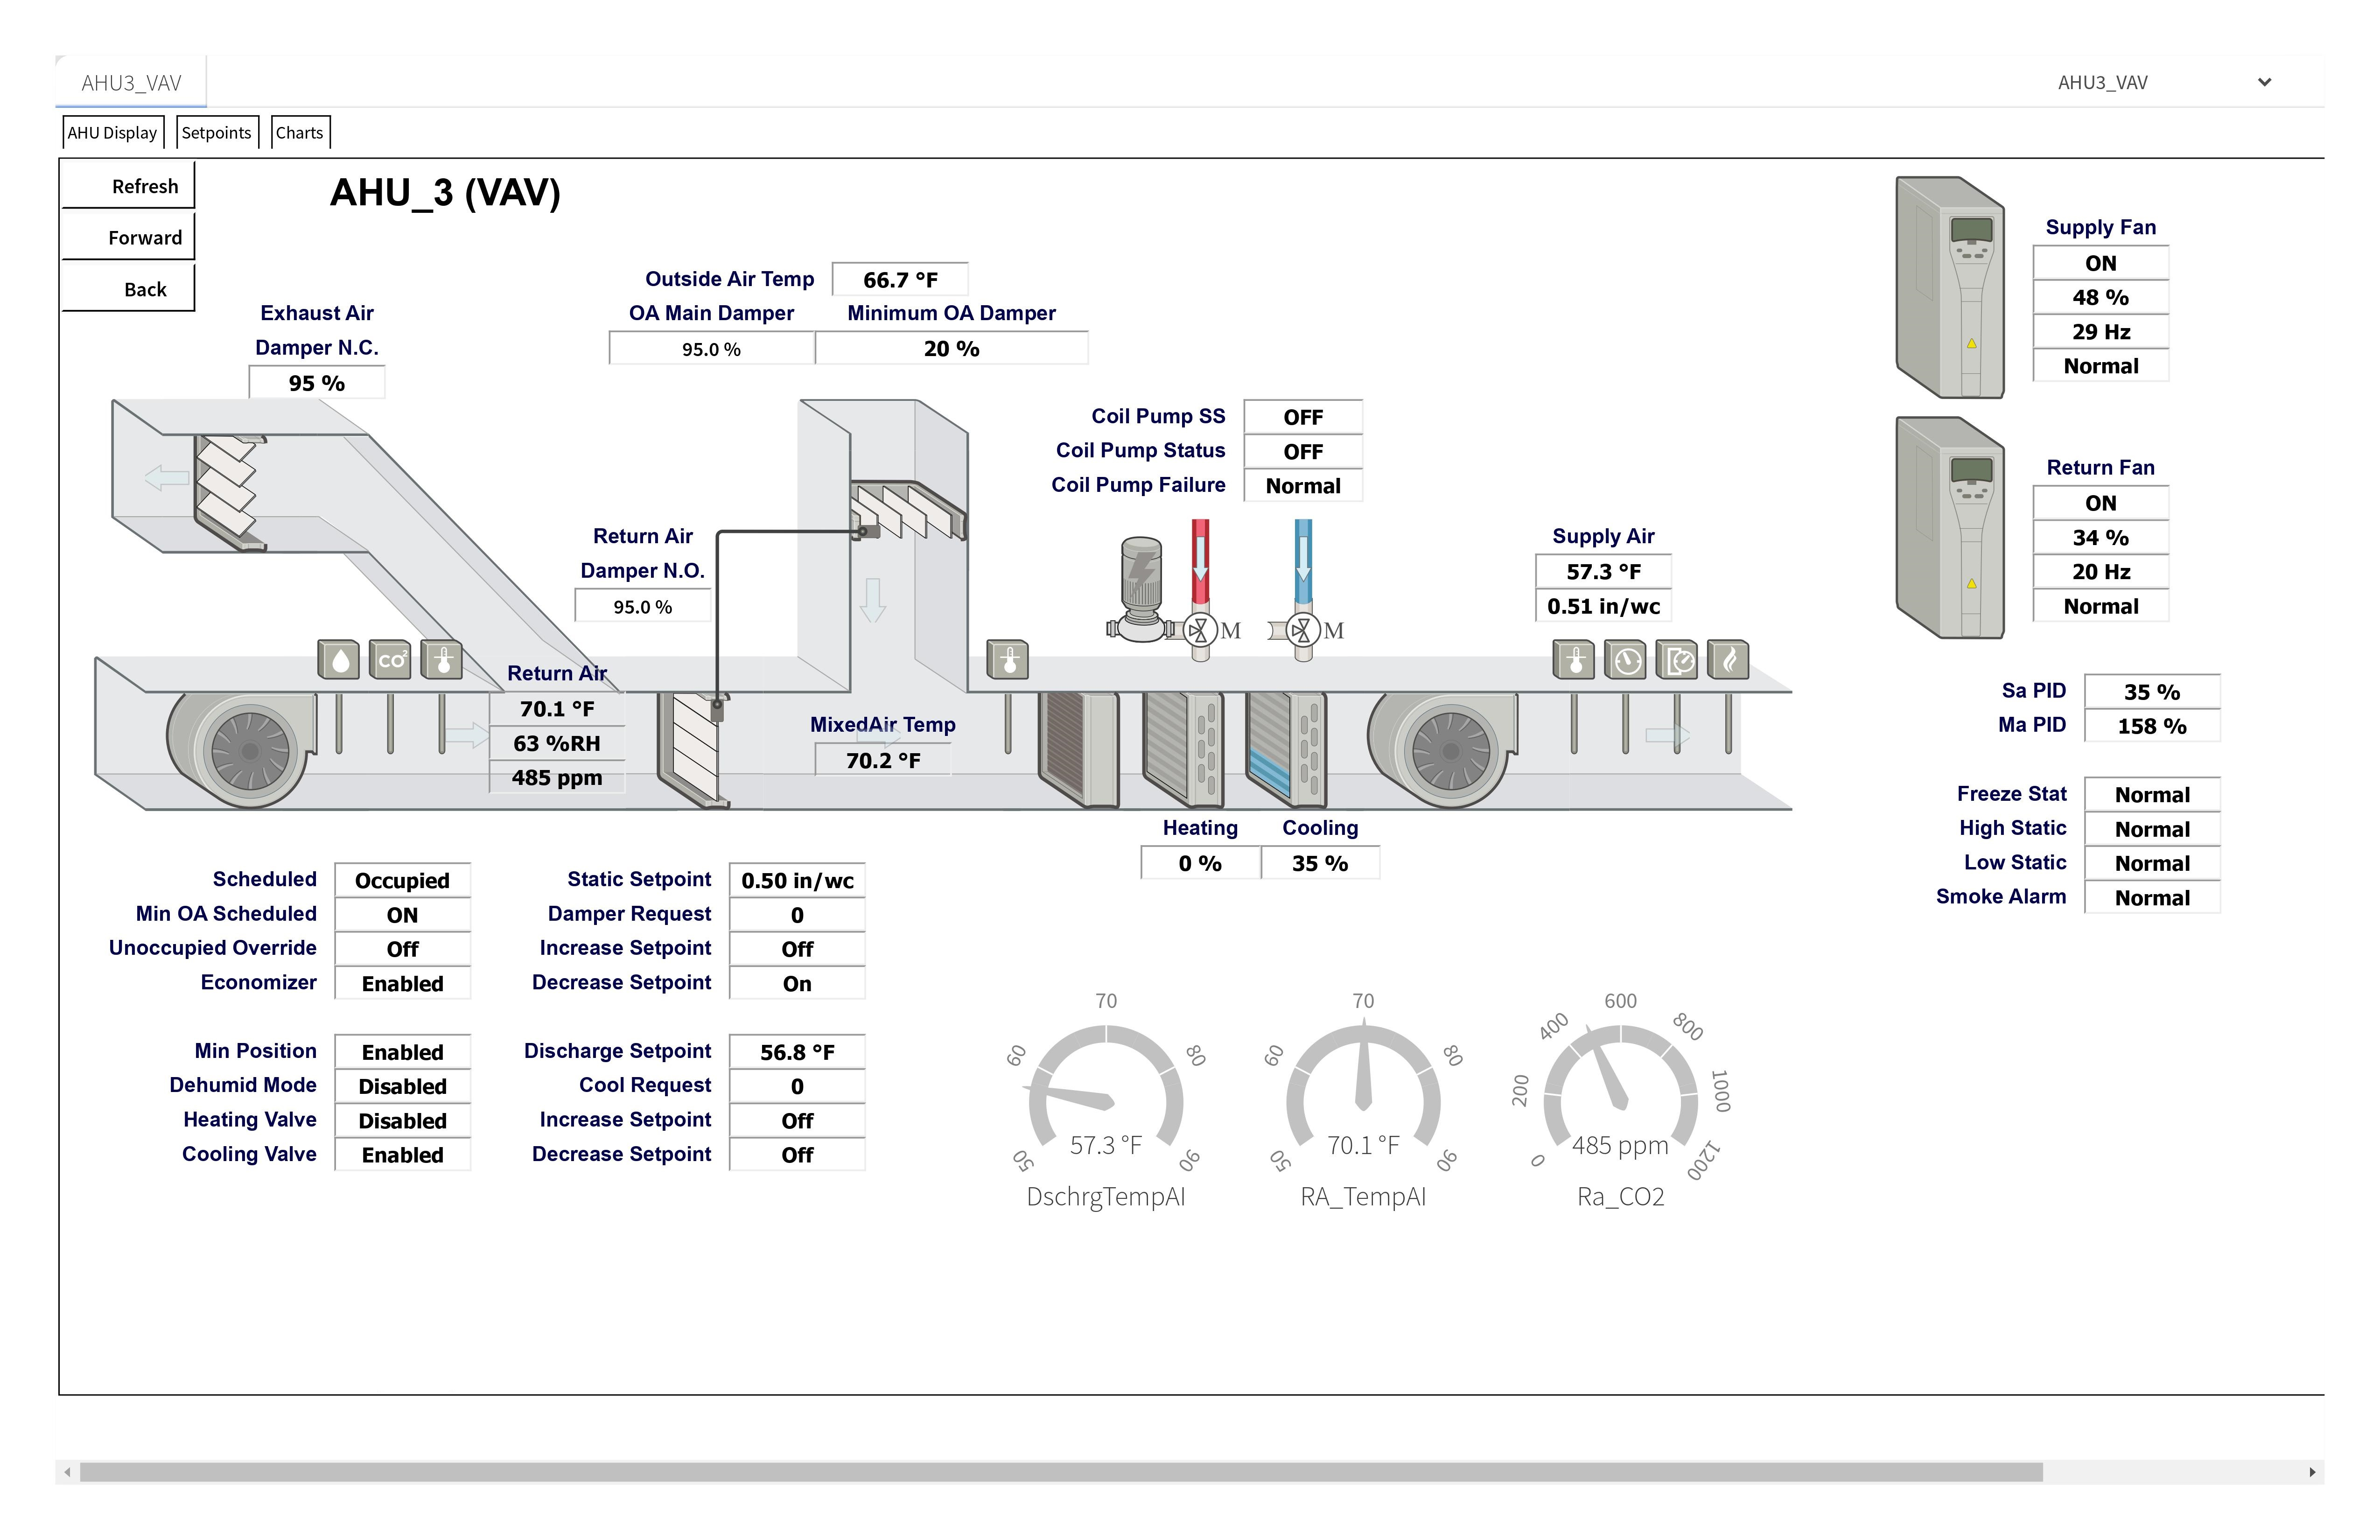

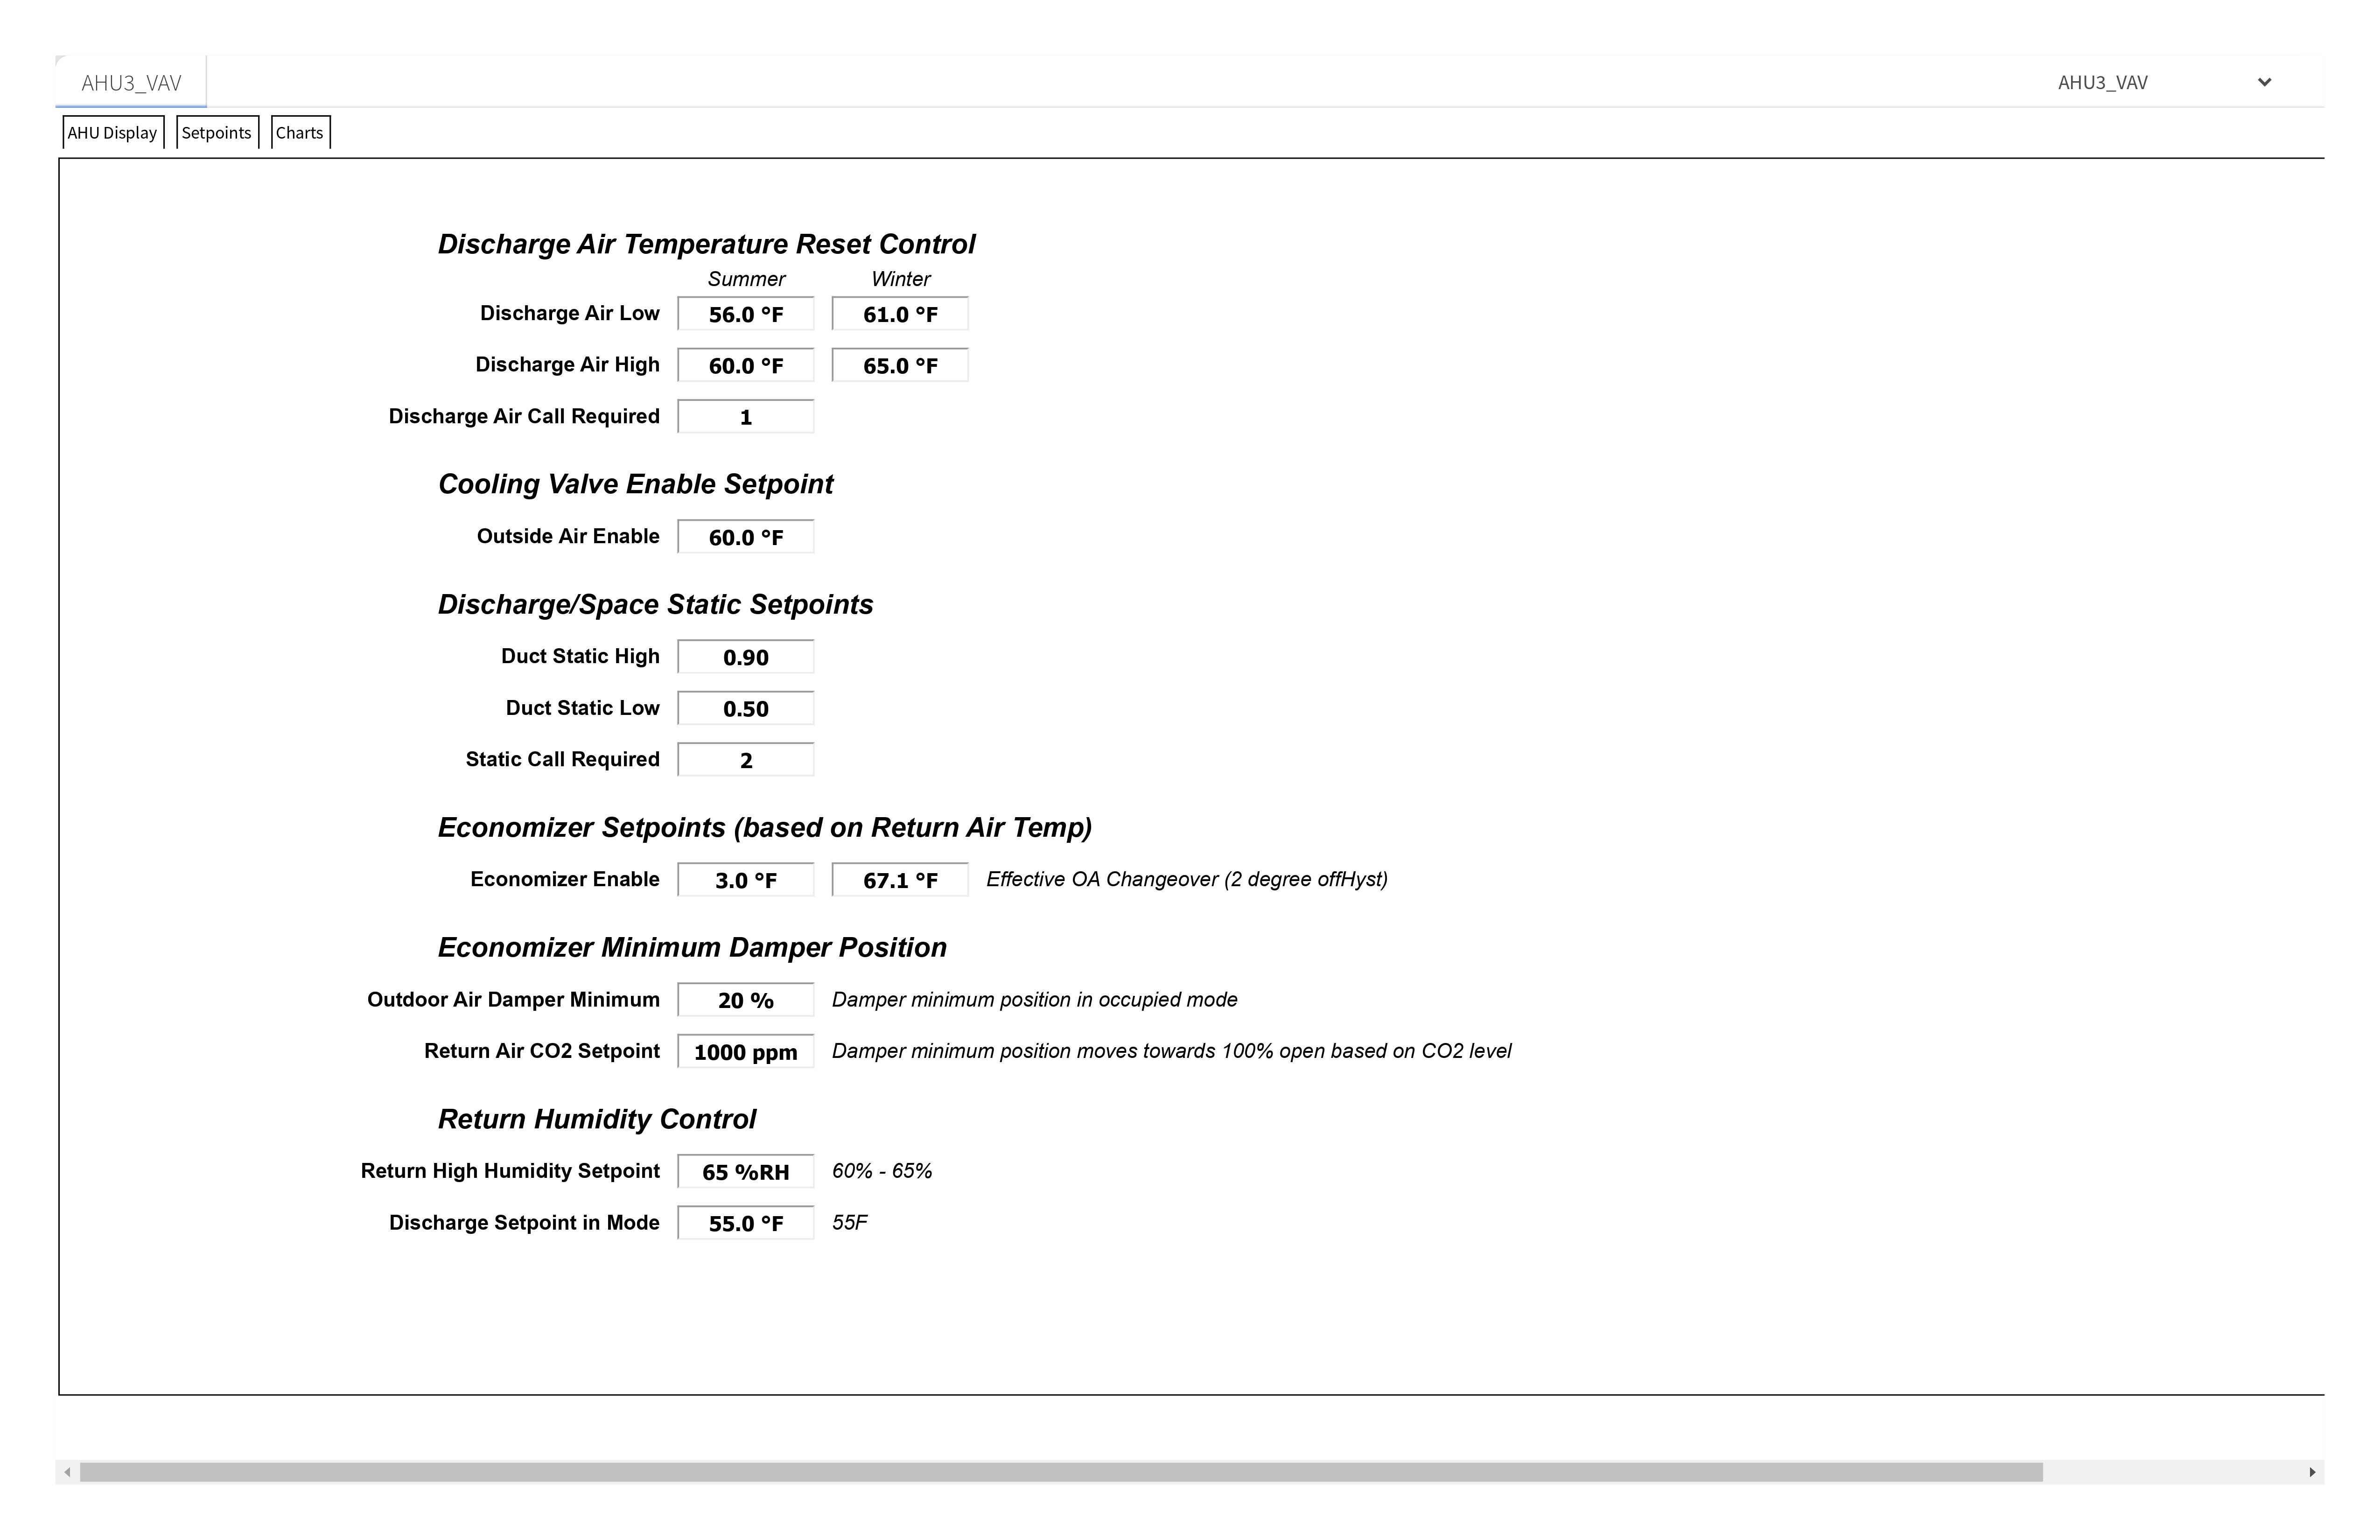

In [3]:
from IPython.display import Image, display

# Specify the path to your JPEG file
image_path1 = r"C:\Users\bbartling\Documents\AHU3_VAV.jpg"
image_path2 = r"C:\Users\bbartling\Documents\AHU3_points.jpg"

# Display the images
display(Image(filename=image_path1))
display(Image(filename=image_path2))

Load data into a Pandas DataFrame
* This data has some chiller/boiler system inlet outlet temps, a few building zone temps, and is mostly AHU data

In [4]:
# Load your data
ahu_data = r"C:\Users\bbartling\Documents\WPCRC_Master.csv"
df = pd.read_csv(ahu_data)

df.head()

timestamp  HWR_value  HWS_value  Heat_Calls  Oa_Temp  \
0  2023-10-01 00:00:00      73.72      73.04         0.0    72.31   
1  2023-10-01 00:05:00      73.72      73.04         0.0    72.22   
2  2023-10-01 00:10:00      73.71      73.04         0.0    72.22   
3  2023-10-01 00:15:00      73.71      73.05         0.0    72.15   
4  2023-10-01 00:20:00      73.70      73.08         0.0    72.09   

   OaTemp_Enable  CWR_Temp  CWS_Temp  CWS_Freeze_SPt  CW_Valve  ...  MA_Temp  \
0           65.0     57.65     55.06             5.0       0.0  ...    73.92   
1           65.0     57.75     55.18             5.0       0.0  ...    73.92   
2           65.0     57.75     55.18             5.0       0.0  ...    73.97   
3           65.0     57.85     55.25             5.0       0.0  ...    74.01   
4           65.0     57.95     55.31             5.0       0.0  ...    74.01   

   EffSetpoint  EaDamper  SpaceTemp  RA_CO2  RA_Temp  VAV2_6_SpaceTemp  \
0         76.0       0.0      70.83  480.97    73.69              72.1   
1         76.0       0.0      70.83  480.97    73.69              72.1   
2         76.0       0.0      70.82  479.02    73.69              72.1   
3         76.0       0.0      70.82  480.96    73.68              72.1   
4         76.0       0.0      70.80  480.95    73.63              72.1   

   VAV2_7_SpaceTemp  VAV3_2_SpaceTemp  VAV3_5_SpaceTemp  
0             73.94             66.99             67.23  
1             73.94             66.99             67.23  
2             73.94             66.99             67.23  
3             73.94             66.99             67.23  
4             73.94             66.99             67.23  

[5 rows x 44 columns]

In [5]:
df.columns

Index(['timestamp', 'HWR_value', 'HWS_value', 'Heat_Calls', 'Oa_Temp',
       'OaTemp_Enable', 'CWR_Temp', 'CWS_Temp', 'CWS_Freeze_SPt', 'CW_Valve',
       'HW_Valve', 'DischargeTemp', 'Eff_DaSP', 'RaHumidity', 'Ra_Temp',
       'Ra_FanSpeed', 'OaTemp', 'Ma_Dampers', 'Ma_Temp', 'SaStaticSPt',
       'Sa_FanSpeed', 'SaTempSP', 'RaCO2', 'SaStatic', 'CurrentKWHrs',
       'CurrentKW', 'Eff_DaSPt', 'RaTemp', 'MaLowSPt', 'MaDampers',
       'SaStatic_SPt', 'SaTempSPt', 'CoolValve', 'OA_Damper', 'MA_Temp',
       'EffSetpoint', 'EaDamper', 'SpaceTemp', 'RA_CO2', 'RA_Temp',
       'VAV2_6_SpaceTemp', 'VAV2_7_SpaceTemp', 'VAV3_2_SpaceTemp',
       'VAV3_5_SpaceTemp'],
      dtype='object')

This code snip below tries to find the outside air damper minimum position which is a required input. It is also noticible in the BAS screenshots above as a `Economizer Minimum Air Damper` for indoor air ventilation requirements. This value is set during building startup by the Testing, Adjusting, and Balancing (TAB) contractor on the BAS (and hopefully not modified by building operators) where TAB uses calibrated flow measurement tools to verify and set that the AHU provides ventilation air volume requirements that the engineer designed in non-economizer AHU operating states (OS).

The Pandas logic attempts to locate when the AHU is operating in cold weather based on the fan speed greater than 15% and the outside air colder than 10°F where then the AHU SHOULD be operating in a min OA mode where then throught the data we should see that 20% value in the 75th percentile. Some data could be capture when the AHU is starting or stopping which is probably why the mean looks sort of funny. Further down we need that `20%` value converted to a `0.2` float for an input.

In [6]:
# Filter the DataFrame
filtered_df = df[(df['Sa_FanSpeed'] > 15.0) & (df['Oa_Temp'] < 10.0)]

# Get the description of the 'OA_Damper' column
oa_damper_description = filtered_df['OA_Damper'].describe()

# Print the description
oa_damper_description

count    3339.000000
mean        9.216119
std         9.964637
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max        20.000000
Name: OA_Damper, dtype: float64

In [7]:
# Checking data types of each column
print("Data Types:")
print(df.dtypes)

Data Types:
timestamp            object
HWR_value           float64
HWS_value           float64
Heat_Calls          float64
Oa_Temp             float64
OaTemp_Enable       float64
CWR_Temp            float64
CWS_Temp            float64
CWS_Freeze_SPt      float64
CW_Valve            float64
HW_Valve            float64
DischargeTemp       float64
Eff_DaSP            float64
RaHumidity          float64
Ra_Temp             float64
Ra_FanSpeed         float64
OaTemp              float64
Ma_Dampers          float64
Ma_Temp             float64
SaStaticSPt         float64
Sa_FanSpeed         float64
SaTempSP            float64
RaCO2               float64
SaStatic            float64
CurrentKWHrs        float64
CurrentKW           float64
Eff_DaSPt           float64
RaTemp              float64
MaLowSPt            float64
MaDampers           float64
SaStatic_SPt        float64
SaTempSPt           float64
CoolValve           float64
OA_Damper           float64
MA_Temp             float64
EffSetpo

In [8]:
# Checking max values of each column
print("\nMax Values:")
print(df.max(numeric_only=True))


Max Values:
HWR_value            178.16
HWS_value            180.55
Heat_Calls            15.00
Oa_Temp               98.55
OaTemp_Enable         75.00
CWR_Temp              92.10
CWS_Temp              91.04
CWS_Freeze_SPt         5.00
CW_Valve             100.00
HW_Valve             100.00
DischargeTemp         96.73
Eff_DaSP              63.00
RaHumidity            88.44
Ra_Temp               81.82
Ra_FanSpeed           86.00
OaTemp                98.55
Ma_Dampers           100.00
Ma_Temp               80.38
SaStaticSPt            0.90
Sa_FanSpeed          100.00
SaTempSP              70.00
RaCO2               1321.36
SaStatic               0.87
CurrentKWHrs          15.30
CurrentKW            120.98
Eff_DaSPt             63.00
RaTemp                79.19
MaLowSPt              64.62
MaDampers             50.00
SaStatic_SPt           0.90
SaTempSPt             70.00
CoolValve            100.00
OA_Damper            100.00
MA_Temp               80.73
EffSetpoint           76.00
EaDampe

### Caveat on Analog Output Data which would be a unit in percent command or position

As seen above printing the max values, please check columns that represent float values ranging from 0 to 100.0 for the control system's analog outputs. Open-fdd expects these values to be in the range of 0 to 1.0 to represent percentages. Some control system data is provided as 0 to 100.0, while others are in the 0 to 1.0 range. If you pass a 0 to 100.0 value for the control system's analog outputs, the check_analog_pct method will flag this as a `ValueError`. This method checks the data type and range of these values, raising an error if the maximum value exceeds 1.0, ensuring that the data conforms to the expected format. Under the hood logic monitors analog outputs to know the operating state (OS) of the AHU based on heating, cooling, and economizer percent commands as well as supply fan speed reference to know when the AHU is running. ASHRAE and NIST use operating states 0, 1, 2, 3 to represent AHU in a heating mode, economizer, economizer plus mechanical cooling, and mechanical cooling only modes.

```python
Sa_FanSpeed          100.00
CW_Valve             100.00
HW_Valve             100.00
Ma_Dampers           100.00
```

In [9]:
# this data has floats between 0.0 and 100.0 so we need to convert to 0.0 and 1.0 ranges
percentage_columns = [
    ["Sa_FanSpeed"],
    ["CW_Valve"],
    ["HW_Valve"],
    ["Ma_Dampers"],
]

for col in percentage_columns:
    df[col] = df[col] / 100.0

df.head()

timestamp  HWR_value  HWS_value  Heat_Calls  Oa_Temp  \
0  2023-10-01 00:00:00      73.72      73.04         0.0    72.31   
1  2023-10-01 00:05:00      73.72      73.04         0.0    72.22   
2  2023-10-01 00:10:00      73.71      73.04         0.0    72.22   
3  2023-10-01 00:15:00      73.71      73.05         0.0    72.15   
4  2023-10-01 00:20:00      73.70      73.08         0.0    72.09   

   OaTemp_Enable  CWR_Temp  CWS_Temp  CWS_Freeze_SPt  CW_Valve  ...  MA_Temp  \
0           65.0     57.65     55.06             5.0       0.0  ...    73.92   
1           65.0     57.75     55.18             5.0       0.0  ...    73.92   
2           65.0     57.75     55.18             5.0       0.0  ...    73.97   
3           65.0     57.85     55.25             5.0       0.0  ...    74.01   
4           65.0     57.95     55.31             5.0       0.0  ...    74.01   

   EffSetpoint  EaDamper  SpaceTemp  RA_CO2  RA_Temp  VAV2_6_SpaceTemp  \
0         76.0       0.0      70.83  480.97    73.69              72.1   
1         76.0       0.0      70.83  480.97    73.69              72.1   
2         76.0       0.0      70.82  479.02    73.69              72.1   
3         76.0       0.0      70.82  480.96    73.68              72.1   
4         76.0       0.0      70.80  480.95    73.63              72.1   

   VAV2_7_SpaceTemp  VAV3_2_SpaceTemp  VAV3_5_SpaceTemp  
0             73.94             66.99             67.23  
1             73.94             66.99             67.23  
2             73.94             66.99             67.23  
3             73.94             66.99             67.23  
4             73.94             66.99             67.23  

[5 rows x 44 columns]

Set the time stamp column as the Pandas DataFrame Index

In [10]:
# Convert the timestamp column to datetime and set it as the index
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

df.head()

HWR_value  HWS_value  Heat_Calls  Oa_Temp  OaTemp_Enable  \
timestamp                                                                       
2023-10-01 00:00:00      73.72      73.04         0.0    72.31           65.0   
2023-10-01 00:05:00      73.72      73.04         0.0    72.22           65.0   
2023-10-01 00:10:00      73.71      73.04         0.0    72.22           65.0   
2023-10-01 00:15:00      73.71      73.05         0.0    72.15           65.0   
2023-10-01 00:20:00      73.70      73.08         0.0    72.09           65.0   

                     CWR_Temp  CWS_Temp  CWS_Freeze_SPt  CW_Valve  HW_Valve  \
timestamp                                                                     
2023-10-01 00:00:00     57.65     55.06             5.0       0.0       0.0   
2023-10-01 00:05:00     57.75     55.18             5.0       0.0       0.0   
2023-10-01 00:10:00     57.75     55.18             5.0       0.0       0.0   
2023-10-01 00:15:00     57.85     55.25             5.0       0.0       0.0   
2023-10-01 00:20:00     57.95     55.31             5.0       0.0       0.0   

                     ...  MA_Temp  EffSetpoint  EaDamper  SpaceTemp  RA_CO2  \
timestamp            ...                                                      
2023-10-01 00:00:00  ...    73.92         76.0       0.0      70.83  480.97   
2023-10-01 00:05:00  ...    73.92         76.0       0.0      70.83  480.97   
2023-10-01 00:10:00  ...    73.97         76.0       0.0      70.82  479.02   
2023-10-01 00:15:00  ...    74.01         76.0       0.0      70.82  480.96   
2023-10-01 00:20:00  ...    74.01         76.0       0.0      70.80  480.95   

                     RA_Temp  VAV2_6_SpaceTemp  VAV2_7_SpaceTemp  \
timestamp                                                          
2023-10-01 00:00:00    73.69              72.1             73.94   
2023-10-01 00:05:00    73.69              72.1             73.94   
2023-10-01 00:10:00    73.69              72.1             73.94   
2023-10-01 00:15:00    73.68              72.1             73.94   
2023-10-01 00:20:00    73.63              72.1             73.94   

                     VAV3_2_SpaceTemp  VAV3_5_SpaceTemp  
timestamp                                                
2023-10-01 00:00:00             66.99             67.23  
2023-10-01 00:05:00             66.99             67.23  
2023-10-01 00:10:00             66.99             67.23  
2023-10-01 00:15:00             66.99             67.23  
2023-10-01 00:20:00             66.99             67.23  

[5 rows x 43 columns]

## Setup the config dict

This Python dictionary stores column names from the Pandas DataFrame along with tuning parameters for the fault logic equations. For more information, please refer to the `air_handling_unit` README on GitHub, specifically under the section titled 'Tutorial for the Config Dict.

https://github.com/bbartling/open-fdd/tree/master/open_fdd/air_handling_unit#readme

In [11]:
# Configuration dictionary
config_dict = {
    # used for report name
    'AHU_NAME': "MZVAV_1",

    # timestamp column name
    'INDEX_COL_NAME': "timestamp",

    'DUCT_STATIC_COL': "SaStatic",
    'DUCT_STATIC_SETPOINT_COL': "SaStaticSPt",
    'SUPPLY_VFD_SPEED_COL': "Sa_FanSpeed",
    'MAT_COL': "MA_Temp",
    'OAT_COL': "OaTemp",
    'SAT_COL': "SaTempSP",
    'RAT_COL': "RaTemp",
    'HEATING_SIG_COL': "HW_Valve",  
    'COOLING_SIG_COL': "CW_Valve",  
    'ECONOMIZER_SIG_COL': "Ma_Dampers",

    # Set to None to potentially skip Fault Condition 6
    'SUPPLY_FAN_AIR_VOLUME_COL': None,  

    # Set to None to potentially skip Fault Condition 14
    'CLG_COIL_ENTER_TEMP_COL': None,
    'CLG_COIL_LEAVE_TEMP_COL': None,

    # Set to None to potentially skip Fault Condition 15
    'HTG_COIL_ENTER_TEMP_COL': None,
    'HTG_COIL_LEAVE_TEMP_COL': None,

    'SAT_SETPOINT_COL': "SaTempSPt",
    'CONSTANT_LEAVE_TEMP_SP': False,
    'CONSTANT_LEAVE_TEMP_SP_VAL': 55.0,

    'VFD_SPEED_PERCENT_ERR_THRES': 0.05,
    'VFD_SPEED_PERCENT_MAX': 0.99,
    'DUCT_STATIC_INCHES_ERR_THRES': 0.1,
    'OUTDOOR_DEGF_ERR_THRES': 5.0,
    'MIX_DEGF_ERR_THRES': 5.0,
    'RETURN_DEGF_ERR_THRES': 2.0,
    'SUPPLY_DEGF_ERR_THRES': 2.0,
    'COIL_TEMP_ENTER_ERR_THRES': 2.0,
    'COIL_TEMP_LEAV_ERR_THRES': 2.0,
    'DELTA_T_SUPPLY_FAN': 2.0,

    'DELTA_OS_MAX': 3,
    'AHU_MIN_OA_DPR': 0.20, # Found from the previous summary stats
    'OAT_RAT_DELTA_MIN': 10,
    'AIRFLOW_ERR_THRES': 0.3,
    'AHU_MIN_OA_CFM_DESIGN': 2500,
    'TROUBLESHOOT_MODE': False,
    'ROLLING_WINDOW_SIZE': 10
}

### process_all_faults

Future tutorials will look at running one fault equation at a time but for now there is a feature to run all faults with the `helper_utils.process_all_faults` method which needs to be imported as shown below where the user passes in the Pandas df and the config dict to retreive 3 items in response. First is the original df with the faults columns added to the df, 2nd is a unique df called `df_fc4` which is a resampled copy of the original df which is special because fault equation 4 defined by ASHRAE resamples data to hourly values to check for excessive operating state changes (PID hunting) as well as a `fault_counts_df` which is just counts of each faults. On really large data sets this can take a few minutes to run due to the fault equation 4 process.

* Also worth mentioning there is a method that `process_all_faults` calls to automatically resample the data to rolling averages if the data passed is 1 minute in frequency or less. ASHRAE recommends 1 minute data on 5 minute rolling averages but sometimes that is not possible to have access to 1 minute sampled data. See here for more information on a `class SharedUtils` that has a method named `apply_rolling_average_if_needed`: 
https://github.com/bbartling/open-fdd/blob/master/open_fdd/air_handling_unit/faults/shared_utils.py


In [12]:
helper_utils = HelperUtils()
df_combined, df_fc4, fault_counts_df = helper_utils.process_all_faults(df, config_dict)

fault_counts_df

to compute AHU OS state changes per hour
to flag any hunting issue
and this usually takes a while to run...


Fault Condition  Count
0    fc1_fault_sum      0
1    fc2_fault_sum      0
2    fc3_fault_sum    182
3    fc4_fault_sum    486
4    fc5_fault_sum      1
5    fc7_fault_sum      0
6    fc8_fault_sum  37924
7    fc9_fault_sum    814
8   fc10_fault_sum    470
9   fc11_fault_sum      0
10  fc12_fault_sum      0
11  fc13_fault_sum    655

There appears to be quite a bit of fault condition (fc) fc3, fc4, fc8, fc9, fc10, and fc13 flags thrown. Further below there is a heat map that we can put them on to see if it has anything to do with time-of-year or weather. See the AHU README for the fault equation descriptions:

https://github.com/bbartling/open-fdd/tree/master/open_fdd/air_handling_unit#ahu-fault-equation-descriptions

* Fault Condition 3: Mix temperature too high; should be between outside and return air
* Fault Condition 4: PID hunting; too many operating state changes between AHU modes for heating, economizer, and mechanical cooling
* Fault Condition 6: OA fraction too low or too high, should equal to design % outdoor air requirement
* Fault Condition 7: Supply air temperature too low in full heating
* Fault Condition 8: Supply air temperature and mix air temperature should be approx equal in economizer mode
* Fault Condition 13: Supply air temperature too high in full cooling in economizer plus mech cooling mode

More than likely some of these are false positives and some tuning params could be adjusted inside the `config_dict` where then the faults can be ran again.

In [13]:
# verify the fc4_flag is added to the df
# remember that df_fc4 is also resampled

df_fc4.columns

Index(['HWR_value', 'HWS_value', 'Heat_Calls', 'Oa_Temp', 'OaTemp_Enable',
       'CWR_Temp', 'CWS_Temp', 'CWS_Freeze_SPt', 'CW_Valve', 'HW_Valve',
       'DischargeTemp', 'Eff_DaSP', 'RaHumidity', 'Ra_Temp', 'Ra_FanSpeed',
       'OaTemp', 'Ma_Dampers', 'Ma_Temp', 'SaStaticSPt', 'Sa_FanSpeed',
       'SaTempSP', 'RaCO2', 'SaStatic', 'CurrentKWHrs', 'CurrentKW',
       'Eff_DaSPt', 'RaTemp', 'MaLowSPt', 'MaDampers', 'SaStatic_SPt',
       'SaTempSPt', 'CoolValve', 'OA_Damper', 'MA_Temp', 'EffSetpoint',
       'EaDamper', 'SpaceTemp', 'RA_CO2', 'RA_Temp', 'VAV2_6_SpaceTemp',
       'VAV2_7_SpaceTemp', 'VAV3_2_SpaceTemp', 'VAV3_5_SpaceTemp',
       'heating_mode', 'econ_only_cooling_mode', 'econ_plus_mech_cooling_mode',
       'mech_cooling_only_mode', 'fc4_flag'],
      dtype='object')

In [14]:
# check that the other fault flags cols were added
df_combined.columns

Index(['HWR_value', 'HWS_value', 'Heat_Calls', 'Oa_Temp', 'OaTemp_Enable',
       'CWR_Temp', 'CWS_Temp', 'CWS_Freeze_SPt', 'CW_Valve', 'HW_Valve',
       'DischargeTemp', 'Eff_DaSP', 'RaHumidity', 'Ra_Temp', 'Ra_FanSpeed',
       'OaTemp', 'Ma_Dampers', 'Ma_Temp', 'SaStaticSPt', 'Sa_FanSpeed',
       'SaTempSP', 'RaCO2', 'SaStatic', 'CurrentKWHrs', 'CurrentKW',
       'Eff_DaSPt', 'RaTemp', 'MaLowSPt', 'MaDampers', 'SaStatic_SPt',
       'SaTempSPt', 'CoolValve', 'OA_Damper', 'MA_Temp', 'EffSetpoint',
       'EaDamper', 'SpaceTemp', 'RA_CO2', 'RA_Temp', 'VAV2_6_SpaceTemp',
       'VAV2_7_SpaceTemp', 'VAV3_2_SpaceTemp', 'VAV3_5_SpaceTemp',
       'static_check_', 'fan_check_', 'combined_check', 'fc1_flag', 'fc2_flag',
       'fc3_flag', 'fc4_flag', 'fc5_flag', 'fc7_flag', 'fc8_flag', 'fc9_flag',
       'fc10_flag', 'fc11_flag', 'fc12_flag', 'fc13_flag'],
      dtype='object')

In [15]:
df_combined.head()

HWR_value  HWS_value  Heat_Calls  Oa_Temp  OaTemp_Enable  \
timestamp                                                                       
2023-10-01 00:00:00      73.72      73.04         0.0    72.31           65.0   
2023-10-01 00:05:00      73.72      73.04         0.0    72.22           65.0   
2023-10-01 00:10:00      73.71      73.04         0.0    72.22           65.0   
2023-10-01 00:15:00      73.71      73.05         0.0    72.15           65.0   
2023-10-01 00:20:00      73.70      73.08         0.0    72.09           65.0   

                     CWR_Temp  CWS_Temp  CWS_Freeze_SPt  CW_Valve  HW_Valve  \
timestamp                                                                     
2023-10-01 00:00:00     57.65     55.06             5.0       0.0       0.0   
2023-10-01 00:05:00     57.75     55.18             5.0       0.0       0.0   
2023-10-01 00:10:00     57.75     55.18             5.0       0.0       0.0   
2023-10-01 00:15:00     57.85     55.25             5.0       0.0       0.0   
2023-10-01 00:20:00     57.95     55.31             5.0       0.0       0.0   

                     ...  fc3_flag  fc4_flag  fc5_flag  fc7_flag  fc8_flag  \
timestamp            ...                                                     
2023-10-01 00:00:00  ...         0       0.0         0         0         0   
2023-10-01 00:05:00  ...         0       NaN         0         0         0   
2023-10-01 00:10:00  ...         0       NaN         0         0         0   
2023-10-01 00:15:00  ...         0       NaN         0         0         0   
2023-10-01 00:20:00  ...         0       NaN         0         0         0   

                     fc9_flag  fc10_flag  fc11_flag  fc12_flag  fc13_flag  
timestamp                                                                  
2023-10-01 00:00:00         0          0          0          0          0  
2023-10-01 00:05:00         0          0          0          0          0  
2023-10-01 00:10:00         0          0          0          0          0  
2023-10-01 00:15:00         0          0          0          0          0  
2023-10-01 00:20:00         0          0          0          0          0  

[5 rows x 58 columns]

# Heat Map

Optional check to see what a heat map would look like for faults. Its interesting to see whatever this fault 8 is that alot of this happening over the Winter. I have a hunch that this AHU has some PID hunting issues (there are some FC4 flags thrown) which causes the economizer damper to open and close even during the Winter time. This AHU is located in upper midwest USA where Winters are very cold and there can be months on end ambient outside air temperature below freezing. 

* I have a hunch this AHU has PID tunning issues on the discharge air temperature control that cause the AHU to constantly be transitioning between heating and cooling where in the Winter time this would be economizing free cooling. This particular building which is just a small to medium sized office type should not require much cooling if any during cold Winter conditions where I think the AHU should be a minimum OA mode and NOT use economizer cooling at all. One thing we did see though in the very beginning was below 10°F the AHU max damper position is the minimum of 20% so that is good. Economizing in cold weather can be a common fault for excessive VAV system reheat as well.

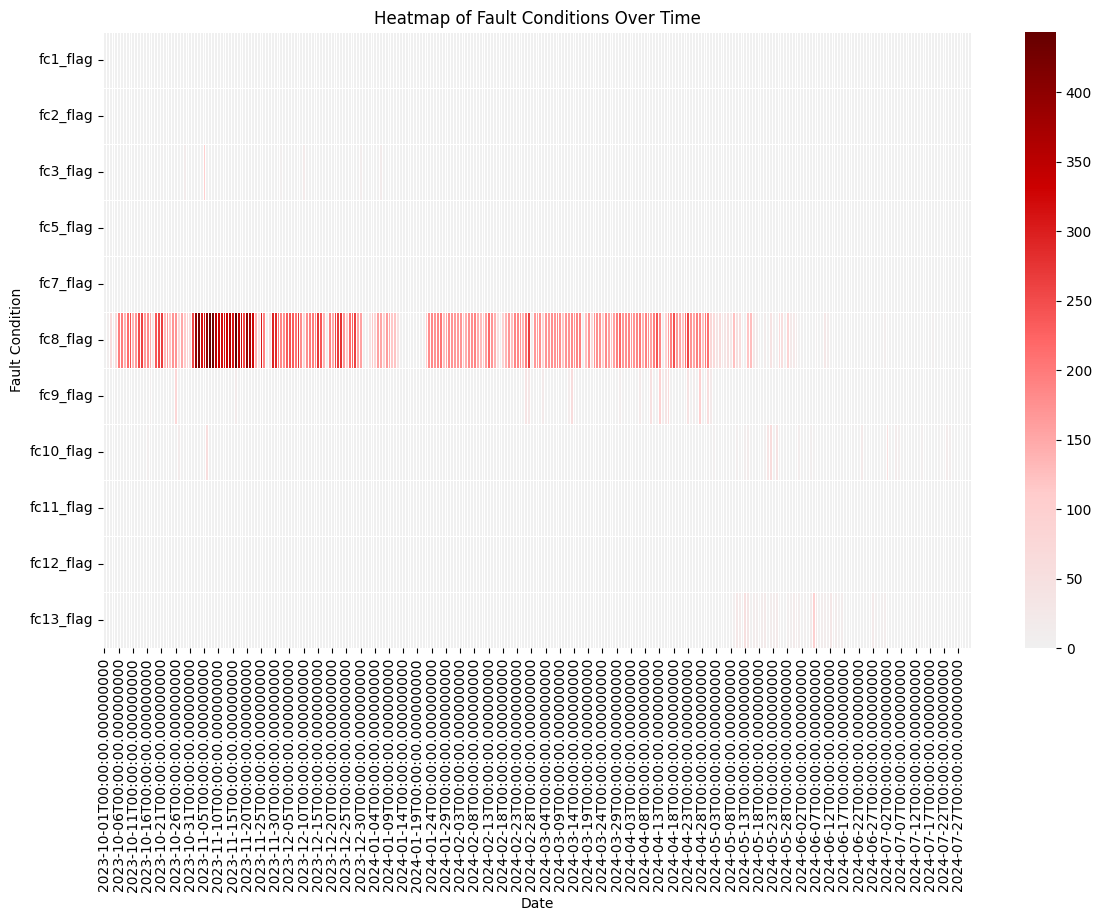

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a copy of df_combined
df_combined_copy = df_combined.copy()

# Resample the data to daily intervals for a clearer heatmap
df_daily = df_combined_copy.resample('D').sum()

# Select only the fault sum columns
fault_columns = ['fc1_flag', 'fc2_flag', 'fc3_flag', 'fc5_flag', 'fc7_flag',
                'fc8_flag', 'fc9_flag', 'fc10_flag', 'fc11_flag', 'fc12_flag', 'fc13_flag']

df_faults = df_daily[fault_columns]

# Transpose for better heatmap visualization
df_faults_t = df_faults.T

# Create a custom color map with more distinction for low values
colors = ["#f0f0f0", "#ffcccc", "#ff6666", "#cc0000", "#660000"]  # light gray to dark red
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Plot heatmap using seaborn
plt.figure(figsize=(14, 8))
sns.heatmap(df_faults_t, cmap=cmap, cbar=True, linewidths=0.5)

plt.title('Heatmap of Fault Conditions Over Time')
plt.xlabel('Date')
plt.ylabel('Fault Condition')
plt.show()


## Reports

open-fdd includes predefined report methods specifically designed to analyze each fault. For instance, the report method for Fault Condition 1 (fc1) automatically plots fan speed, duct static pressure, and duct static pressure setpoint without requiring any additional configuration in Pandas.

Given that this dataset spans nearly a year, I’m focusing on one month at a time for report plotting purposes. Please adjust as necessary.

In [17]:
# Filter the DataFrame for just one month of data
df_combined = df_combined.loc["2024-01"]

df_combined

HWR_value  HWS_value  Heat_Calls  Oa_Temp  OaTemp_Enable  \
timestamp                                                                       
2024-01-01 00:00:00     140.61     144.21         3.0    30.78           75.0   
2024-01-01 00:05:00     139.46     147.24         3.0    33.31           75.0   
2024-01-01 00:10:00     145.29     152.27         2.0    33.98           75.0   
2024-01-01 00:15:00     148.76     152.13         2.0    32.61           75.0   
2024-01-01 00:20:00     149.58     151.28         2.0    29.52           75.0   
...                        ...        ...         ...      ...            ...   
2024-01-31 23:35:00     133.29     133.43         2.0    37.90           75.0   
2024-01-31 23:40:00     133.89     134.81         2.0    37.83           75.0   
2024-01-31 23:45:00     136.47     138.46         2.0    37.56           75.0   
2024-01-31 23:50:00     139.22     140.95         2.0    37.43           75.0   
2024-01-31 23:55:00     141.50     142.08         2.0    37.47           75.0   

                     CWR_Temp  CWS_Temp  CWS_Freeze_SPt  CW_Valve  HW_Valve  \
timestamp                                                                     
2024-01-01 00:00:00     65.91     61.93             5.0       0.0    0.0000   
2024-01-01 00:05:00     65.90     61.93             5.0       0.0    0.2477   
2024-01-01 00:10:00     65.90     61.93             5.0       0.0    0.0000   
2024-01-01 00:15:00     65.90     61.92             5.0       0.0    0.0000   
2024-01-01 00:20:00     65.90     61.92             5.0       0.0    0.0000   
...                       ...       ...             ...       ...       ...   
2024-01-31 23:35:00     67.17     67.13             5.0       0.0    0.0000   
2024-01-31 23:40:00     67.17     67.12             5.0       0.0    0.0000   
2024-01-31 23:45:00     67.17     67.13             5.0       0.0    0.0000   
2024-01-31 23:50:00     67.17     67.12             5.0       0.0    0.0000   
2024-01-31 23:55:00     67.17     67.13             5.0       0.0    0.0000   

                     ...  fc3_flag  fc4_flag  fc5_flag  fc7_flag  fc8_flag  \
timestamp            ...                                                     
2024-01-01 00:00:00  ...         0       0.0         0         0         0   
2024-01-01 00:05:00  ...         0       NaN         0         0         0   
2024-01-01 00:10:00  ...         0       NaN         0         0         0   
2024-01-01 00:15:00  ...         0       NaN         0         0         0   
2024-01-01 00:20:00  ...         0       NaN         0         0         0   
...                  ...       ...       ...       ...       ...       ...   
2024-01-31 23:35:00  ...         0       NaN         0         0         0   
2024-01-31 23:40:00  ...         0       NaN         0         0         0   
2024-01-31 23:45:00  ...         0       NaN         0         0         0   
2024-01-31 23:50:00  ...         0       NaN         0         0         0   
2024-01-31 23:55:00  ...         0       NaN         0         0         0   

                     fc9_flag  fc10_flag  fc11_flag  fc12_flag  fc13_flag  
timestamp                                                                  
2024-01-01 00:00:00         0          0          0          0          0  
2024-01-01 00:05:00         0          0          0          0          0  
2024-01-01 00:10:00         0          0          0          0          0  
2024-01-01 00:15:00         0          0          0          0          0  
2024-01-01 00:20:00         0          0          0          0          0  
...                       ...        ...        ...        ...        ...  
2024-01-31 23:35:00         0          0          0          0          0  
2024-01-31 23:40:00         0          0          0          0          0  
2024-01-31 23:45:00         0          0          0          0          0  
2024-01-31 23:50:00         0          0          0          0          0  
2024-01-31 2

These cell below I am just running one at a time for each fault equation. Under the hood in the reporting methods some metrics are printed to console just for reference purposes. 

### Fault Condition 1: Variable supply fan does not meet duct static pressure setpoint at full speed

$$
\text{DSP} < \text{DPSP} - \text{eDSP} \quad \text{and} \quad \text{VFDSPD} \geq 99\% - \text{eVFDSPD}
$$

Fault Condition 1: Duct static too low at fan at full speed


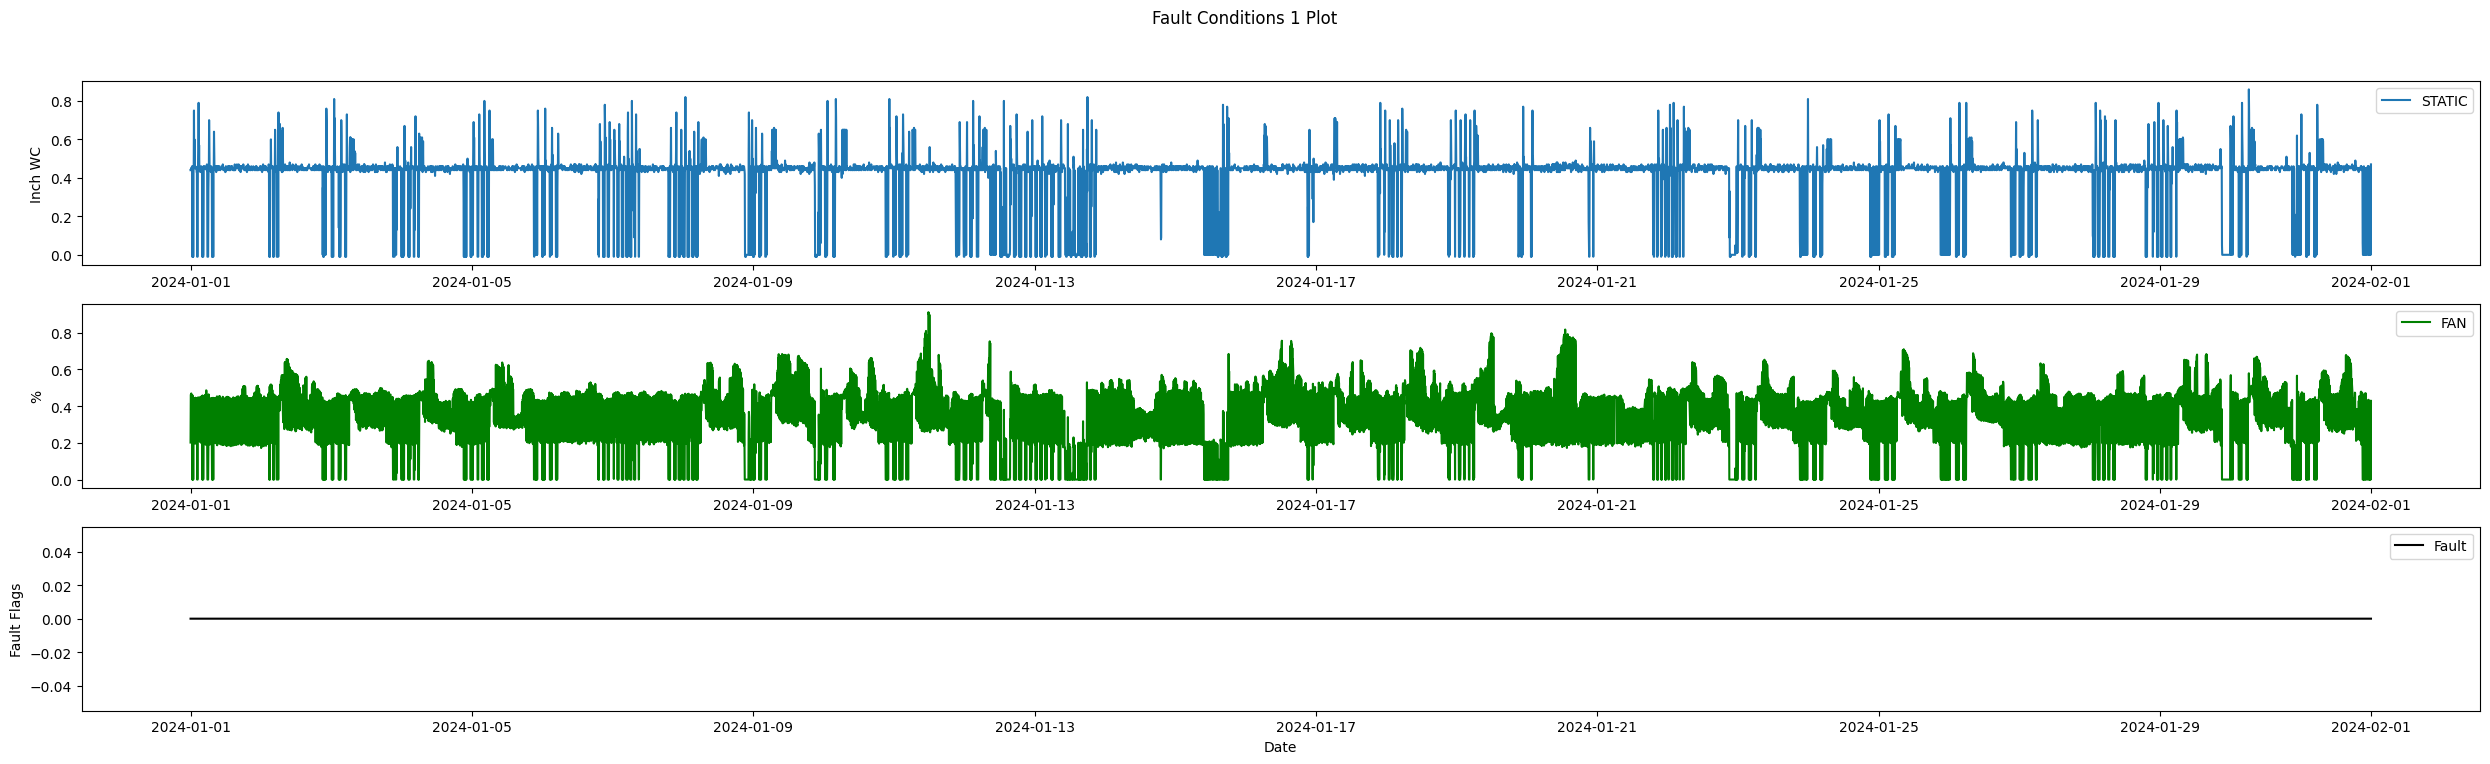

total days: 31.0
total hours: 744
hours fc1 mode: 0
percent true: 0.0
percent false: 100.0
flag true duct static: nan
flag true duct static spt: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [18]:
from open_fdd.air_handling_unit.reports.report_fc1 import FaultCodeOneReport

# Create an instance of FaultCodeFourReport
fc1_report = FaultCodeOneReport(config_dict)
fc1_report.display_report_in_ipython(df_combined)

### Fault Condition 2: Mix Temperature Too Low
$$
\text{MAT} + \text{eMAT} < \min(\text{RAT} - \text{eRAT}, \text{OAT} - \text{eOAT}) \quad \text{and} \quad \text{VFDSPD} > 0.01
$$

Fault Condition 2: Mix temperature too low; should be between outside and return air


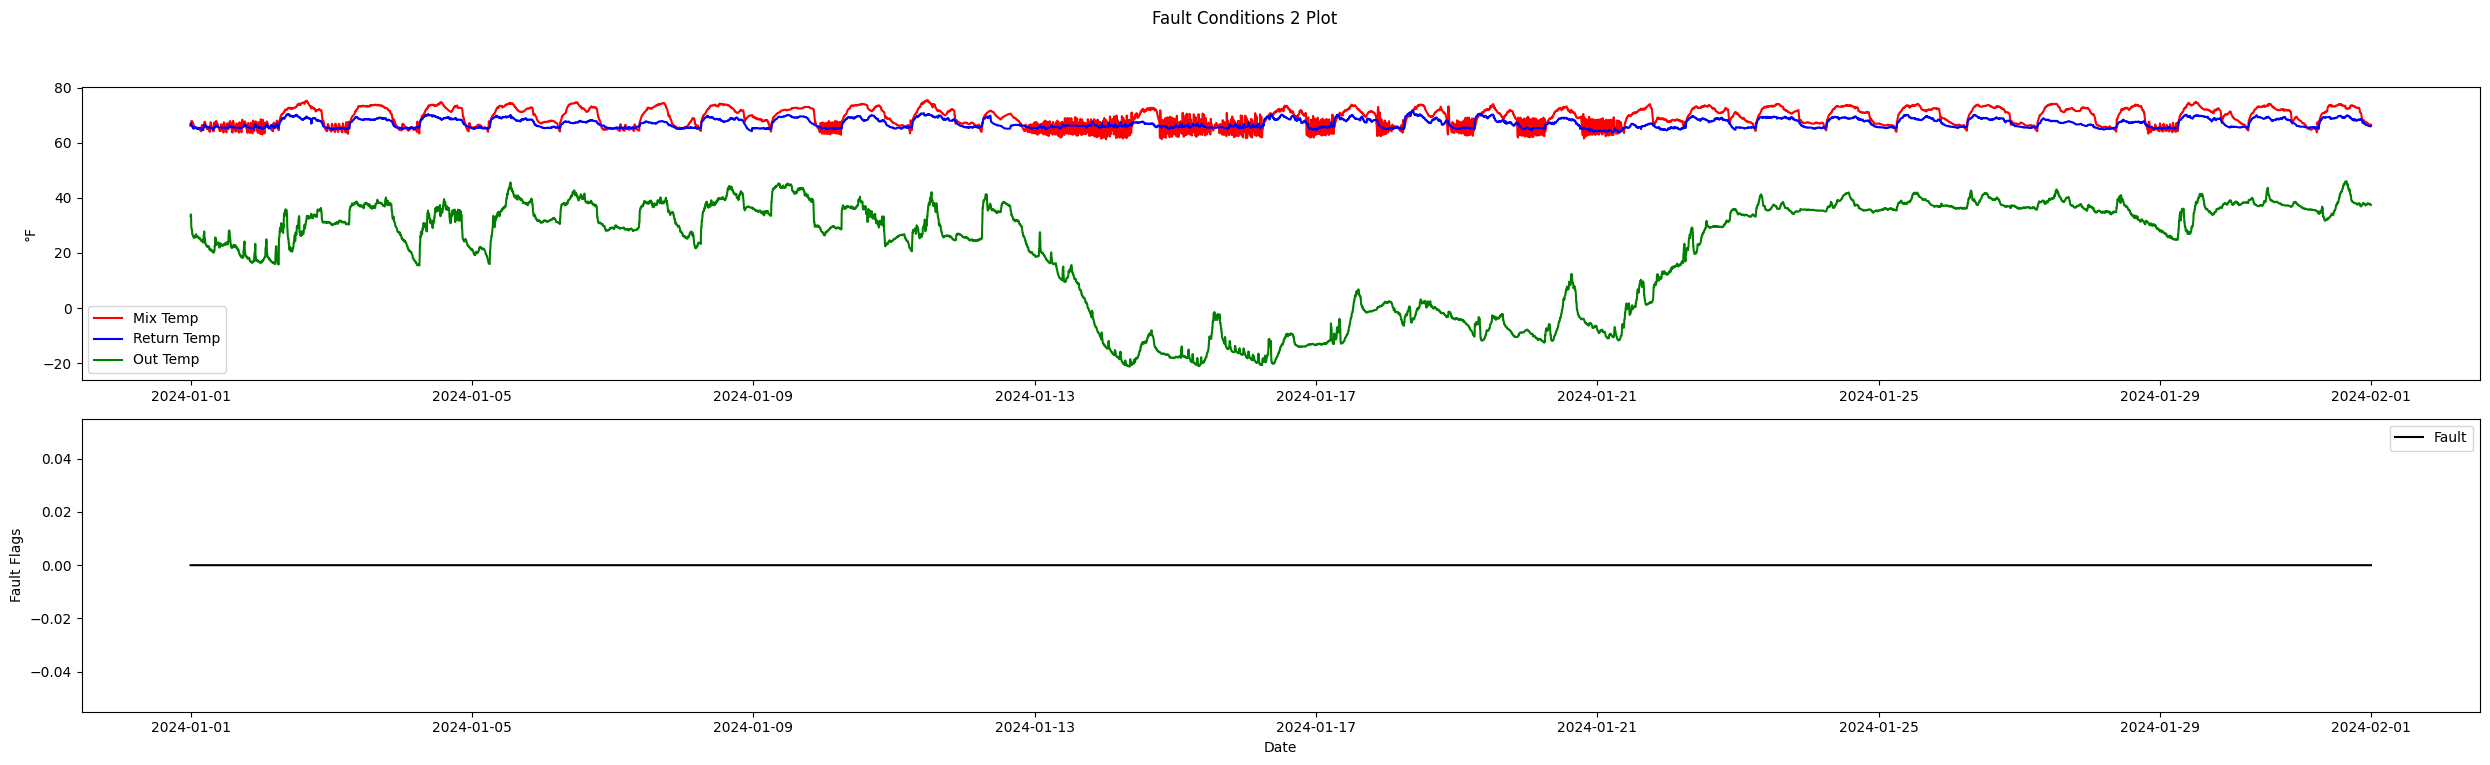

total days: 31.0
total hours: 744
hours fc2 mode: 0
percent true: 0.0
percent false: 100.0
flag true mat: nan
flag true oat: nan
flag true rat: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [19]:
from open_fdd.air_handling_unit.reports.report_fc2 import FaultCodeTwoReport

# Create an instance of FaultCodeFourReport
fc2_report = FaultCodeTwoReport(config_dict)
fc2_report.display_report_in_ipython(df_combined)

### Fault Condition 3: Mix Temperature Too High
$$
\text{MAT} - \text{eMAT} > \max(\text{RAT} + \text{eRAT}, \text{OAT} + \text{eOAT}) \quad \text{and} \quad \text{VFDSPD} > 0.01
$$

Fault Condition 3: Mix temperature too high; should be between outside and return air


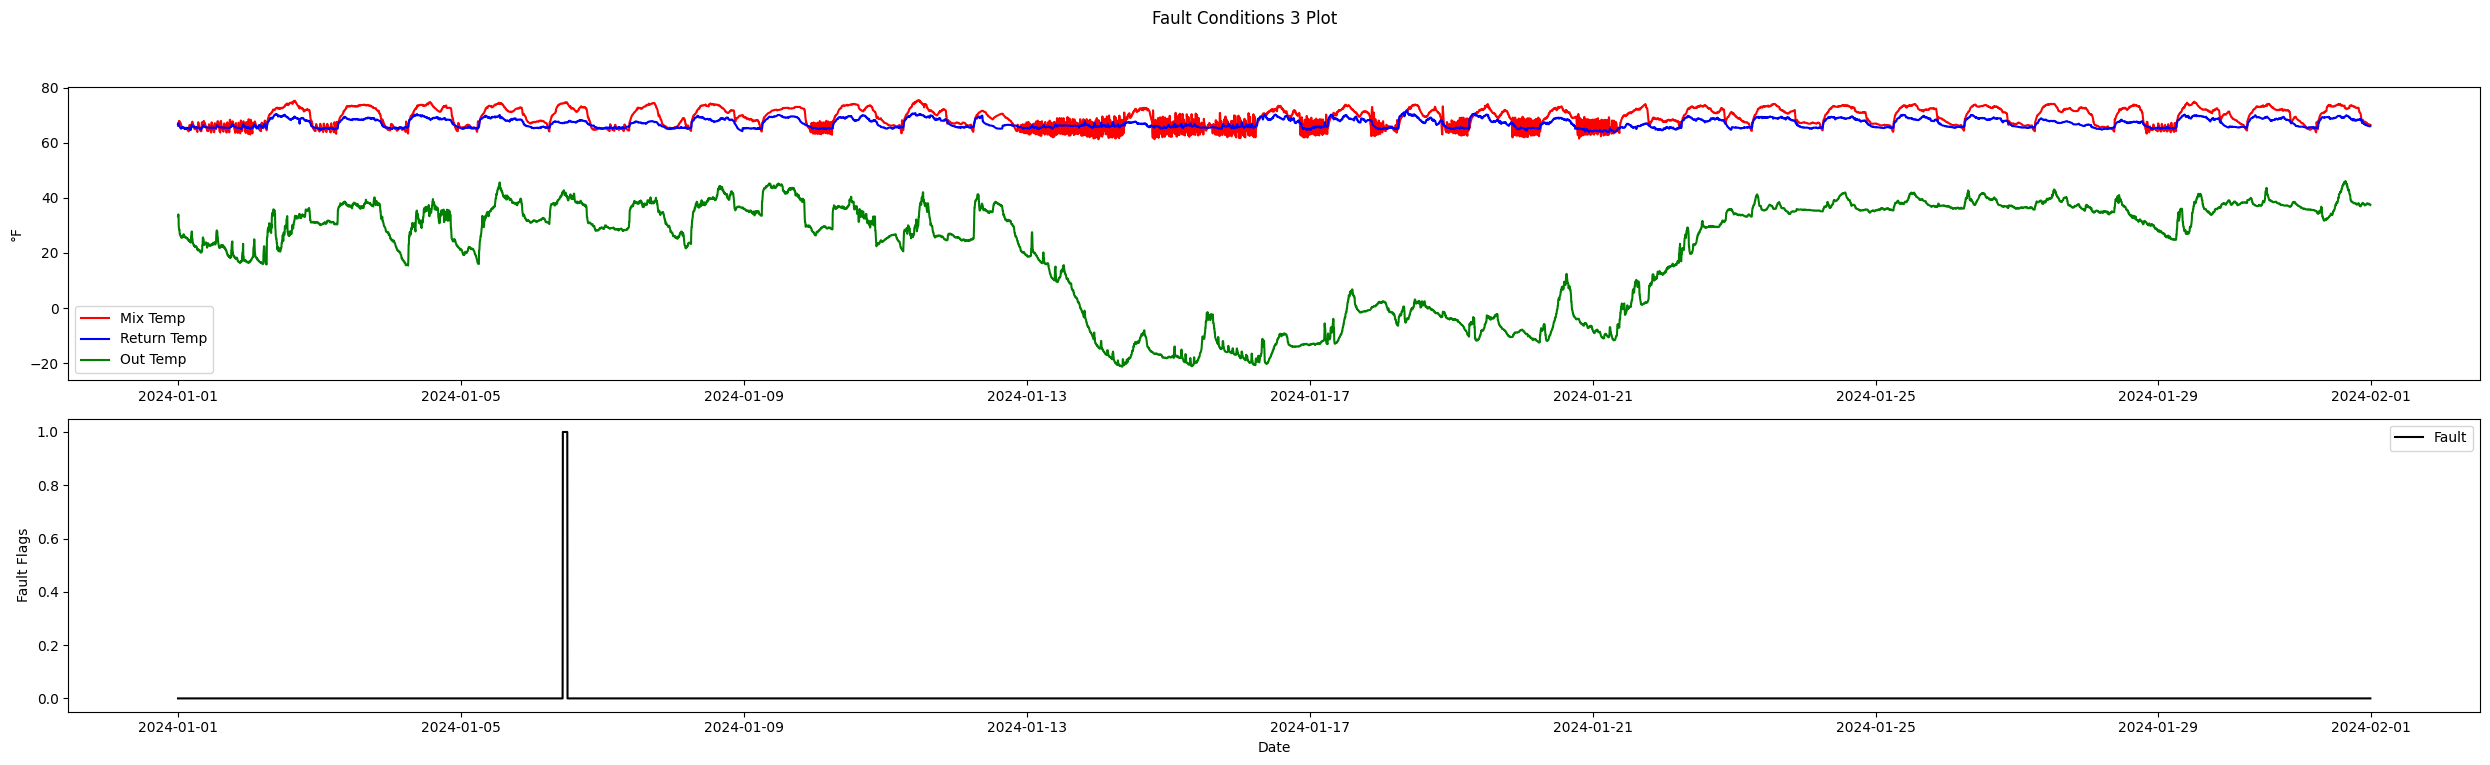

total days: 31.0
total hours: 744
hours fc3 mode: 2
percent true: 0.21
percent false: 99.79
flag true mat: 74.45
flag true oat: 41.43
flag true rat: 67.27
hours motor runtime: 669.0
Fault Flag Count:  1


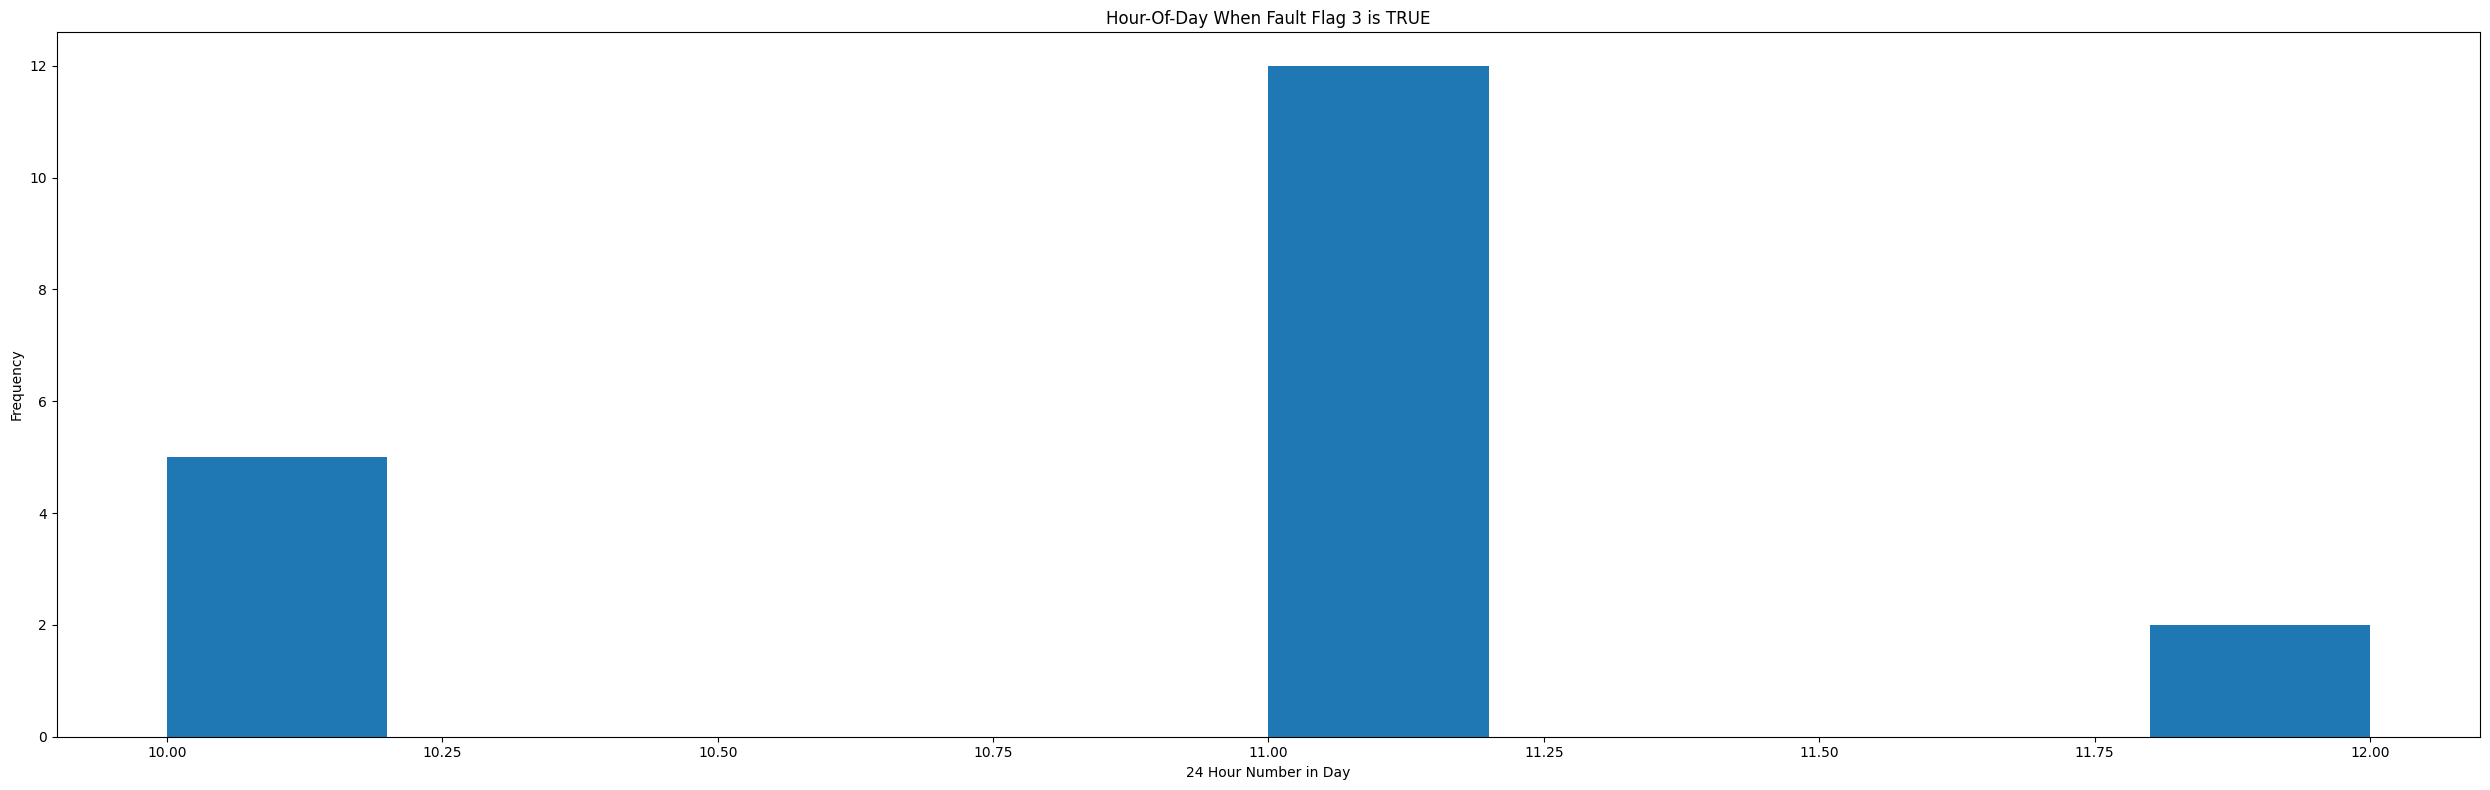

Mix Air Temp Mean When In Fault:  74.45
Outside Air Temp Mean When In Fault:  41.43
Return Temp Mean When In Fault:  67.27
The percent True metric that represents the amount of time for when the fault flag is True is low, indicating the system is likely functioning correctly.


In [20]:
from open_fdd.air_handling_unit.reports.report_fc3 import FaultCodeThreeReport

# Create an instance of FaultCodeFourReport
fc3_report = FaultCodeThreeReport(config_dict)
fc3_report.display_report_in_ipython(df_combined)


### Fault Condition 4: Excessive Operating State Changes
* Keep in mind that Fault Equation 4 (`df_fc4`) involves resampling data to hourly sums of the AHU's operating states (OS) based on analog output commands. 

$$
\text{OS\_Changes\_Per\_Hour} > \text{Delta\_OS\_Max}
$$

#### Operating States Definitions:

**Heating Mode**:
$$
\text{Heating\_Sig} > 0 \quad \text{and} \quad \text{Cooling\_Sig} = 0 \quad \text{and} \quad \text{VFDSPD} > 0 \quad \text{and} \quad \text{Econ\_Sig} = \text{Min\_OA\_DPR}
$$

**Economizer Only Cooling Mode**:
$$
\text{Heating\_Sig} = 0 \quad \text{and} \quad \text{Cooling\_Sig} = 0 \quad \text{and} \quad \text{VFDSPD} > 0 \quad \text{and} \quad \text{Econ\_Sig} > \text{Min\_OA\_DPR}
$$

**Economizer Plus Mechanical Cooling Mode**:
$$
\text{Heating\_Sig} = 0 \quad \text{and} \quad \text{Cooling\_Sig} > 0 \quad \text{and} \quad \text{VFDSPD} > 0 \quad \text{and} \quad \text{Econ\_Sig} > \text{Min\_OA\_DPR}
$$

**Mechanical Cooling Only Mode**:
$$
\text{Heating\_Sig} = 0 \quad \text{and} \quad \text{Cooling\_Sig} > 0 \quad \text{and} \quad \text{VFDSPD} > 0 \quad \text{and} \quad \text{Econ\_Sig} = \text{Min\_OA\_DPR}
$$


Fault Condition 4: Hunting too many OS state changes


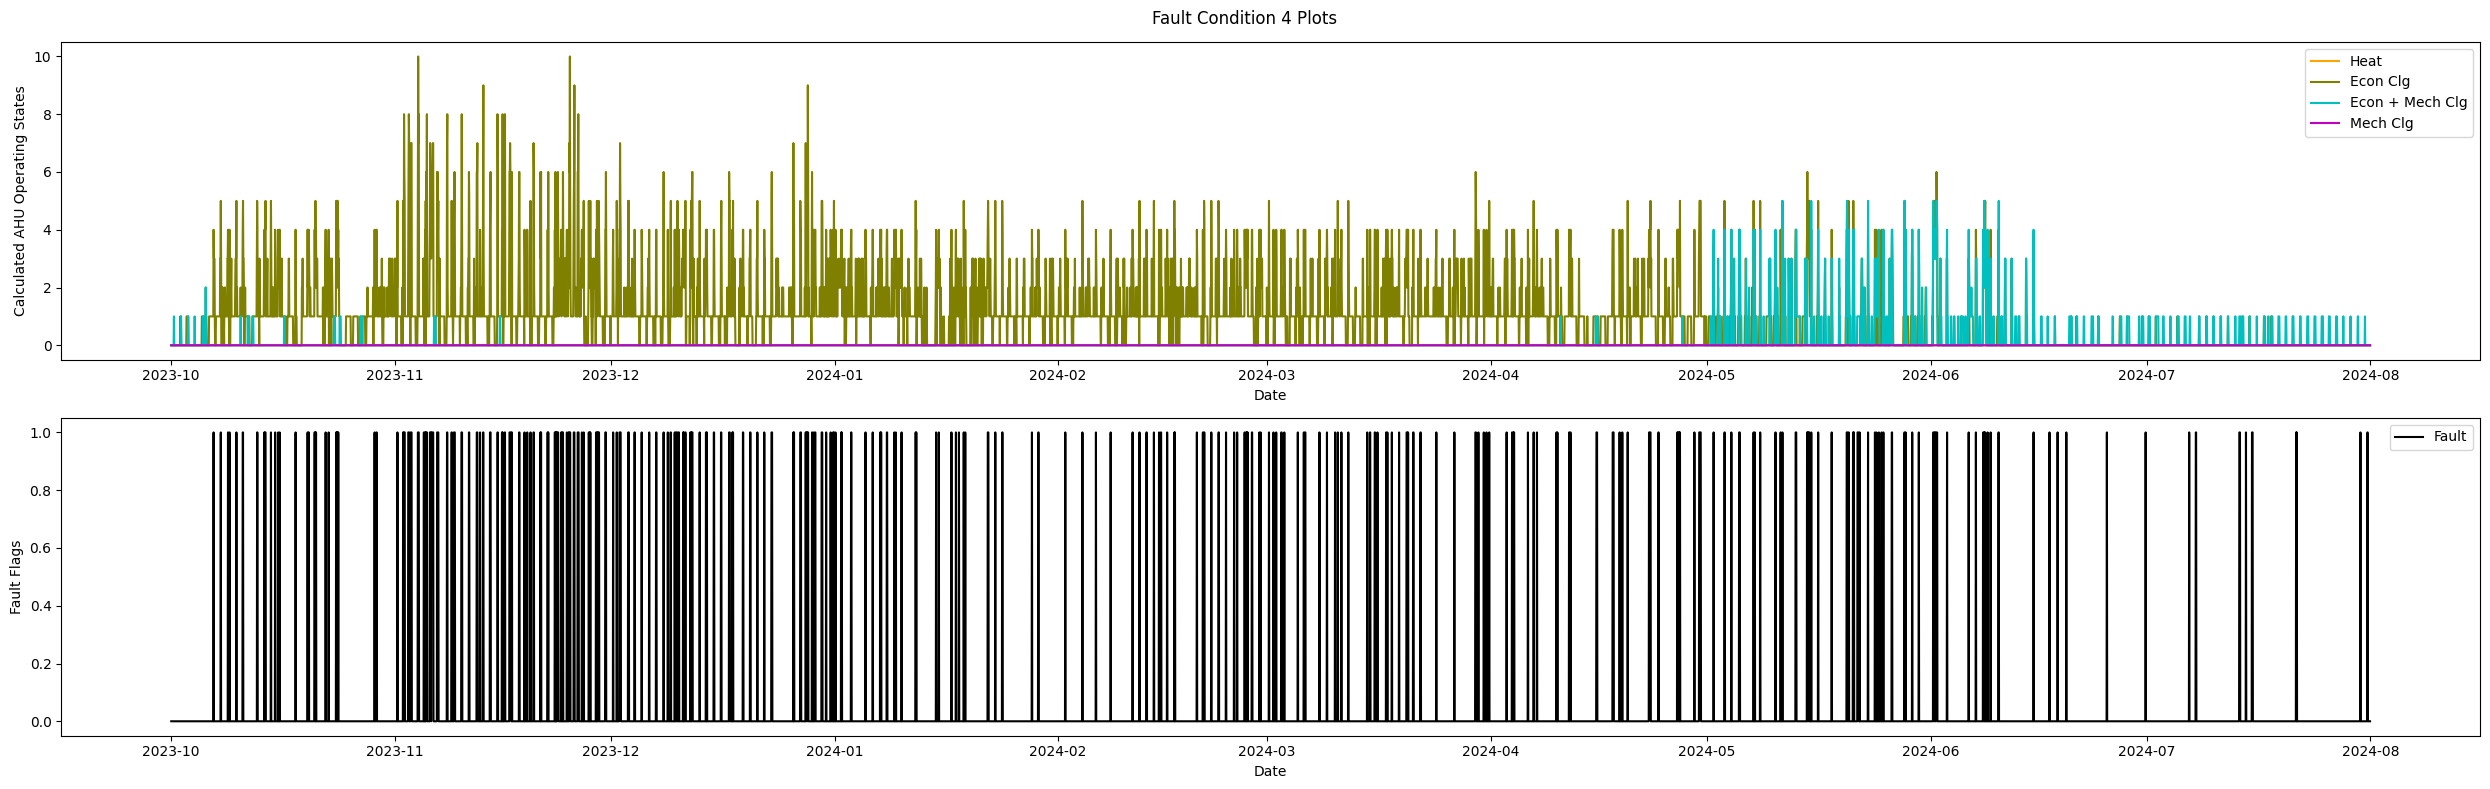

total days: 304.96
total hours: 7319
hours in fault: 486
percent of time in fault: 6.64
percent of time not in fault: 93.36
percent of time AHU in mech clg mode: 0.0
percent of time AHU in econ plus mech clg mode: 11.57
percent of time AHU in econ free clg mode: 107.13
percent of time AHU in heating mode: 0.0
total hours heating mode: 0.0
total hours econ mode: 7842.0
total hours econ mech clg mode: 847.0
total hours mech clg mode: 0.0
Fault Flag Count:  1

Time-of-day Histogram Data
timestamp
2023-10-06 21:00:00    21.0
2023-10-07 21:00:00    21.0
2023-10-08 21:00:00    21.0
2023-10-09 02:00:00     2.0
2023-10-10 01:00:00     1.0
                       ... 
2024-07-21 17:00:00    17.0
2024-07-21 19:00:00    19.0
2024-07-30 15:00:00    15.0
2024-07-31 14:00:00    14.0
2024-07-31 15:00:00    15.0
Name: hour_of_the_day, Length: 486, dtype: float64



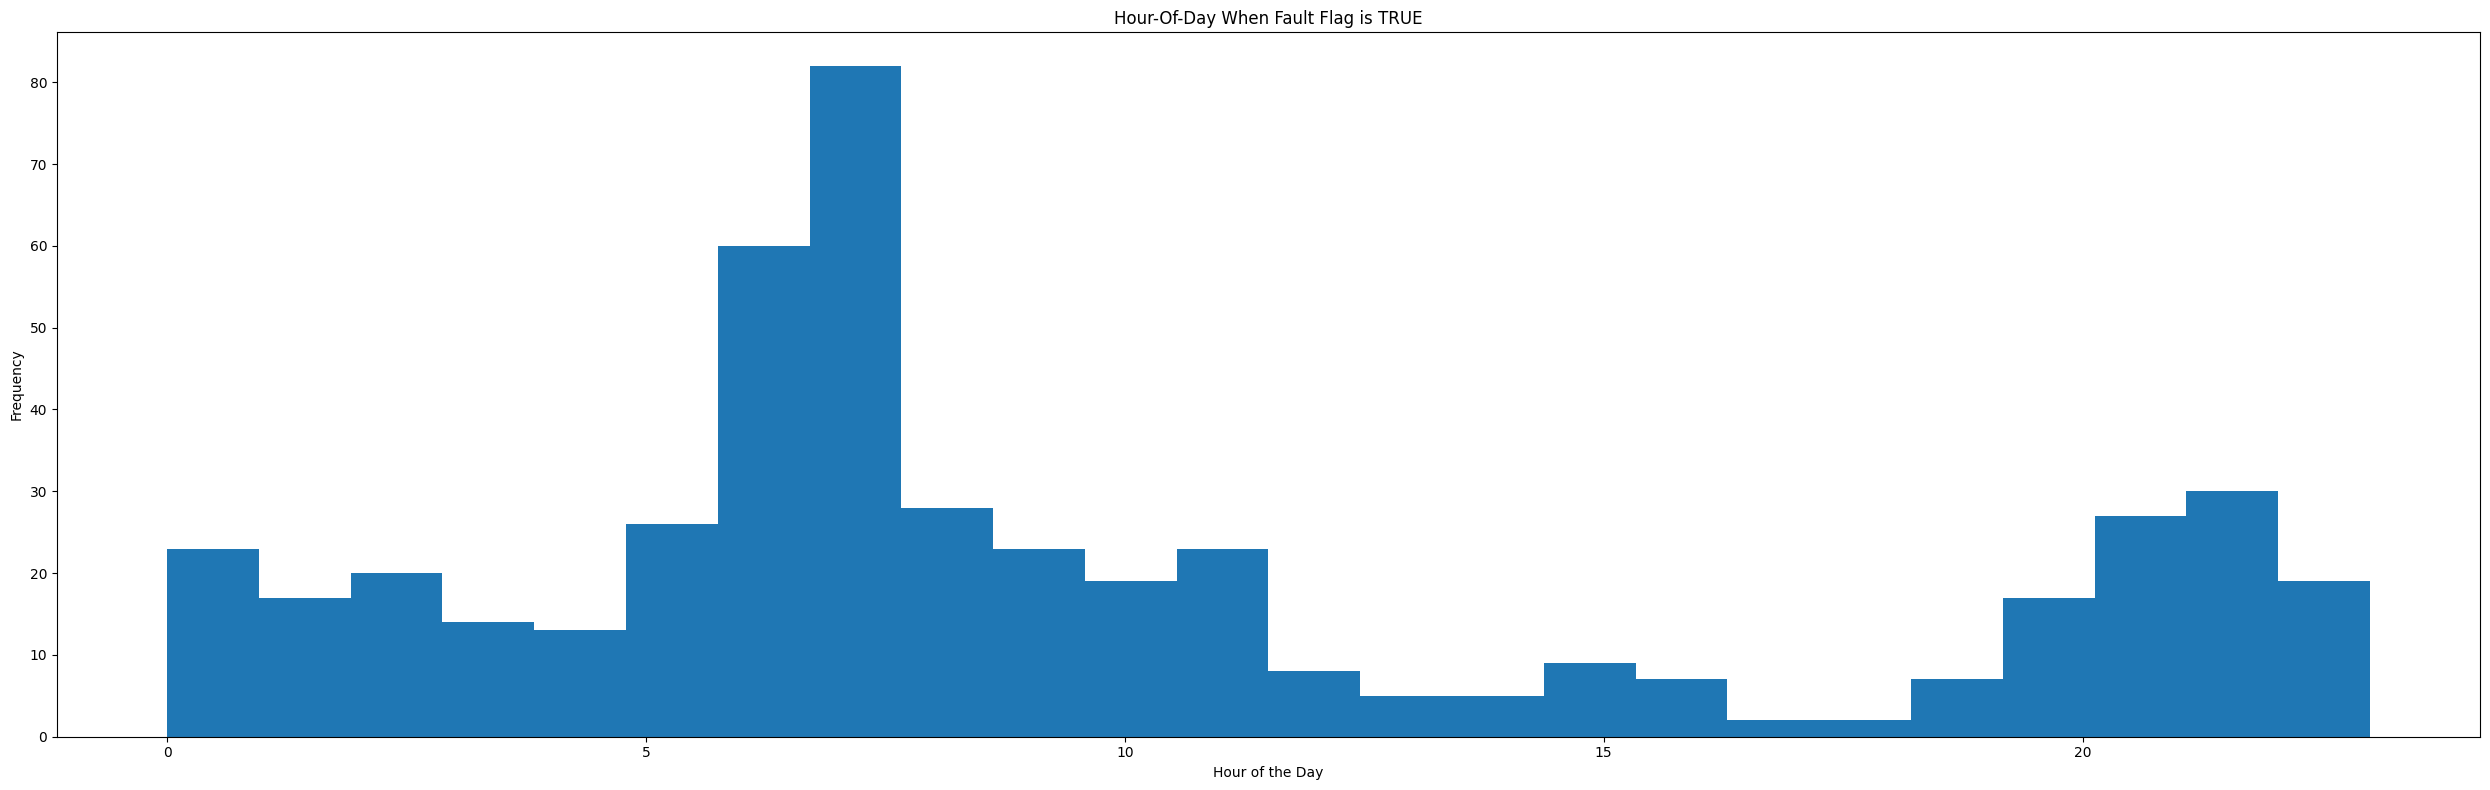

In [21]:

from open_fdd.air_handling_unit.reports.report_fc4 import FaultCodeFourReport

# Create an instance of FaultCodeFourReport
fc4_report = FaultCodeFourReport(config_dict)
fc4_report.display_report_in_ipython(df_fc4)

Lets also resample the fault 4 df down to just the month of January and run it again

In [22]:
# Filter the DataFrame for just one month of data
df_fc4 = df_fc4.loc["2024-01"]

df_fc4

HWR_value  HWS_value  Heat_Calls  Oa_Temp  OaTemp_Enable  \
timestamp                                                                       
2024-01-01 00:00:00          0          0           0        0              0   
2024-01-01 01:00:00          0          0           0        0              0   
2024-01-01 02:00:00          0          0           0        0              0   
2024-01-01 03:00:00          0          0           0        0              0   
2024-01-01 04:00:00          0          0           0        0              0   
...                        ...        ...         ...      ...            ...   
2024-01-31 19:00:00          0          0           1        0              0   
2024-01-31 20:00:00          0          0           1        0              0   
2024-01-31 21:00:00          0          0           1        0              0   
2024-01-31 22:00:00          0          0           0        0              0   
2024-01-31 23:00:00          0          0           0        0              0   

                     CWR_Temp  CWS_Temp  CWS_Freeze_SPt  CW_Valve  HW_Valve  \
timestamp                                                                     
2024-01-01 00:00:00         0         0               0         0         0   
2024-01-01 01:00:00         0         0               0         0         0   
2024-01-01 02:00:00         0         0               0         0         0   
2024-01-01 03:00:00         0         0               0         0         0   
2024-01-01 04:00:00         0         0               0         0         0   
...                       ...       ...             ...       ...       ...   
2024-01-31 19:00:00         0         0               0         0         0   
2024-01-31 20:00:00         0         0               0         0         0   
2024-01-31 21:00:00         0         0               0         0         0   
2024-01-31 22:00:00         0         0               0         0         0   
2024-01-31 23:00:00         0         0               0         0         0   

                     ...  VAV2_6_SpaceTemp  VAV2_7_SpaceTemp  \
timestamp            ...                                       
2024-01-01 00:00:00  ...                 0                 0   
2024-01-01 01:00:00  ...                 0                 0   
2024-01-01 02:00:00  ...                 0                 0   
2024-01-01 03:00:00  ...                 0                 0   
2024-01-01 04:00:00  ...                 0                 0   
...                  ...               ...               ...   
2024-01-31 19:00:00  ...                 0                 0   
2024-01-31 20:00:00  ...                 0                 0   
2024-01-31 21:00:00  ...                 0                 0   
2024-01-31 22:00:00  ...                 0                 0   
2024-01-31 23:00:00  ...                 0                 0   

                     VAV3_2_SpaceTemp  VAV3_5_SpaceTemp  heating_mode  \
timestamp                                                               
2024-01-01 00:00:00                 0                 0             0   
2024-01-01 01:00:00                 0                 0             0   
2024-01-01 02:00:00                 0                 0             0   
2024-01-01 03:00:00                 0                 0             0   
2024-01-01 04:00:00                 0                 0             0   
...                               ...               ...           ...   
2024-01-31 19:00:00                 0                 0             0   
2024-01-31 20:00:00                 0                 0             0   
2024-01-31 21:00:00                 0                 0             0   
2024-01-31 22:00:00                 0                 0             0   
2024-01-31 23:00:00                 0                 0             0   

                     econ_only_cooling_mode  econ_plus_mech_cooling_mode  \
timestamp                                                                  
2024

Fault Condition 4: Hunting too many OS state changes


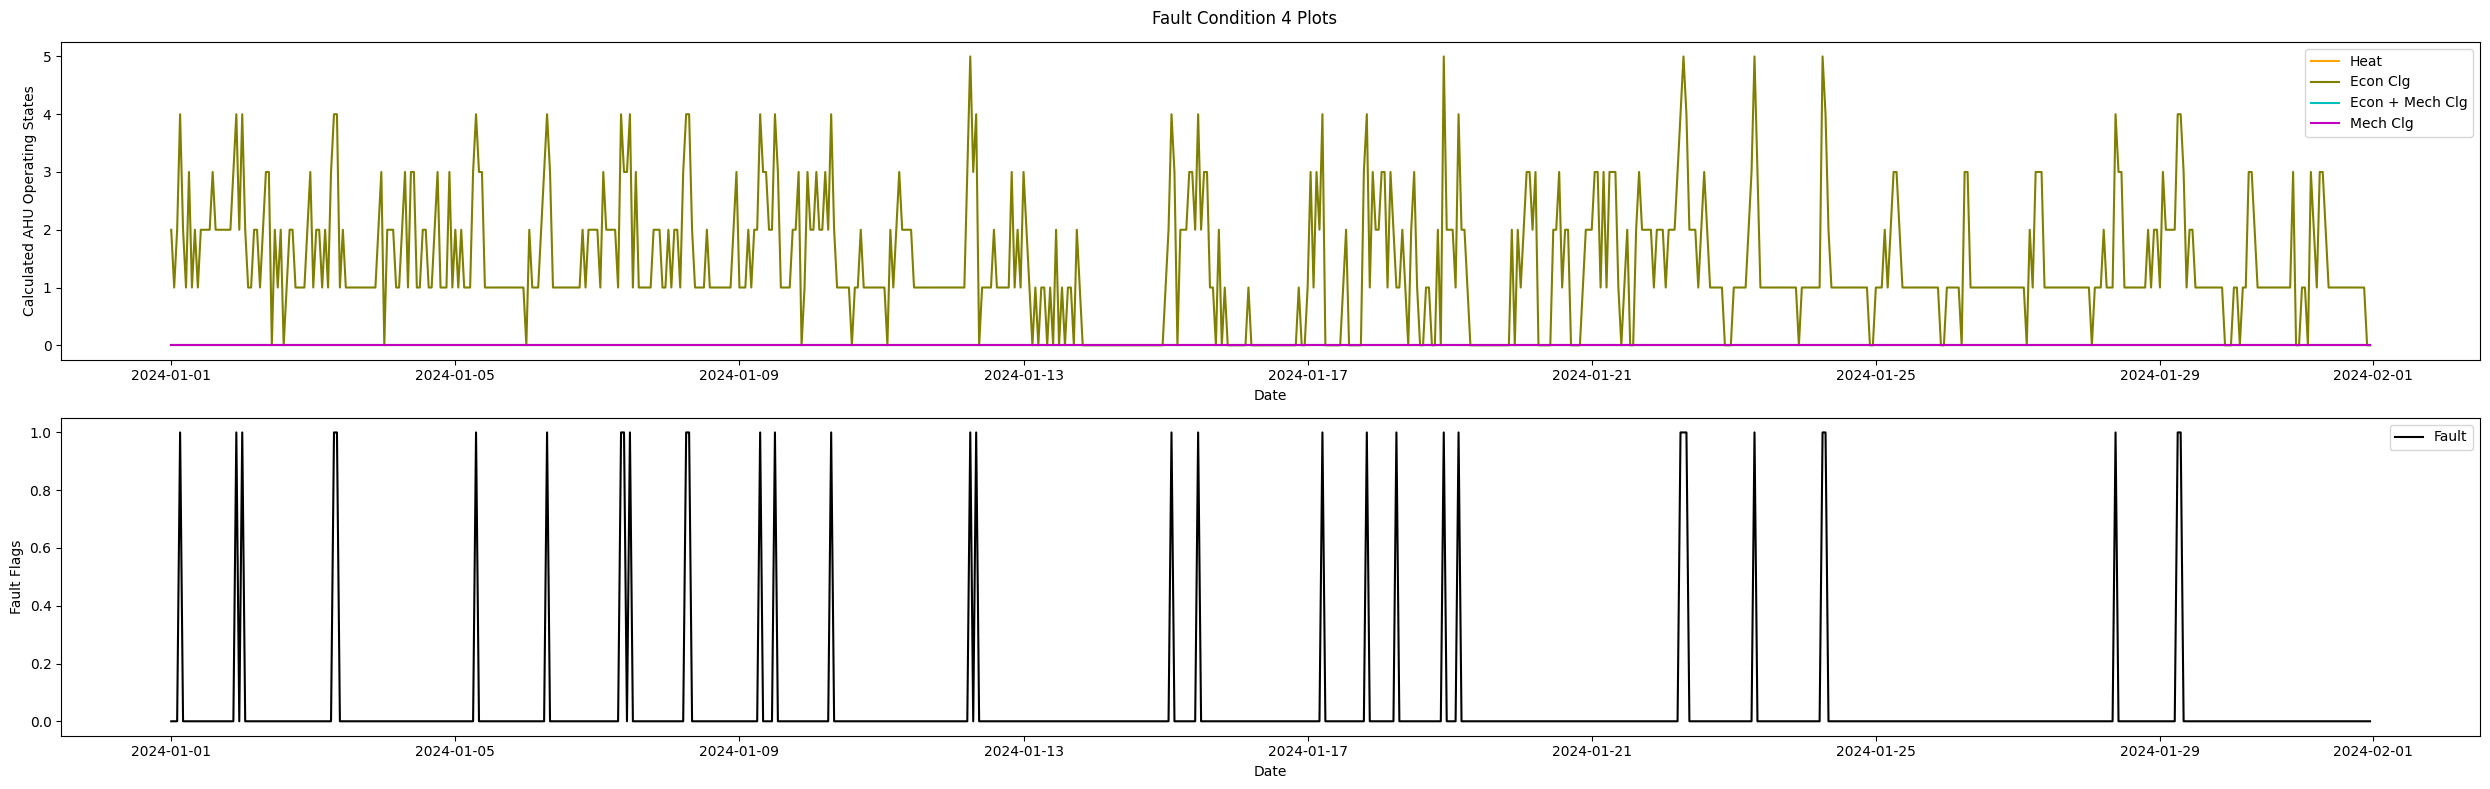

total days: 30.96
total hours: 743
hours in fault: 33
percent of time in fault: 4.44
percent of time not in fault: 95.56
percent of time AHU in mech clg mode: 0.0
percent of time AHU in econ plus mech clg mode: 0.0
percent of time AHU in econ free clg mode: 136.96
percent of time AHU in heating mode: 0.0
total hours heating mode: 0.0
total hours econ mode: 1017.0
total hours econ mech clg mode: 0.0
total hours mech clg mode: 0.0
Fault Flag Count:  1

Time-of-day Histogram Data
timestamp
2024-01-01 03:00:00     3.0
2024-01-01 22:00:00    22.0
2024-01-02 00:00:00     0.0
2024-01-03 07:00:00     7.0
2024-01-03 08:00:00     8.0
2024-01-05 07:00:00     7.0
2024-01-06 07:00:00     7.0
2024-01-07 08:00:00     8.0
2024-01-07 09:00:00     9.0
2024-01-07 11:00:00    11.0
2024-01-08 06:00:00     6.0
2024-01-08 07:00:00     7.0
2024-01-09 07:00:00     7.0
2024-01-09 12:00:00    12.0
2024-01-10 07:00:00     7.0
2024-01-12 06:00:00     6.0
2024-01-12 08:00:00     8.0
2024-01-15 02:00:00     2.0
2024

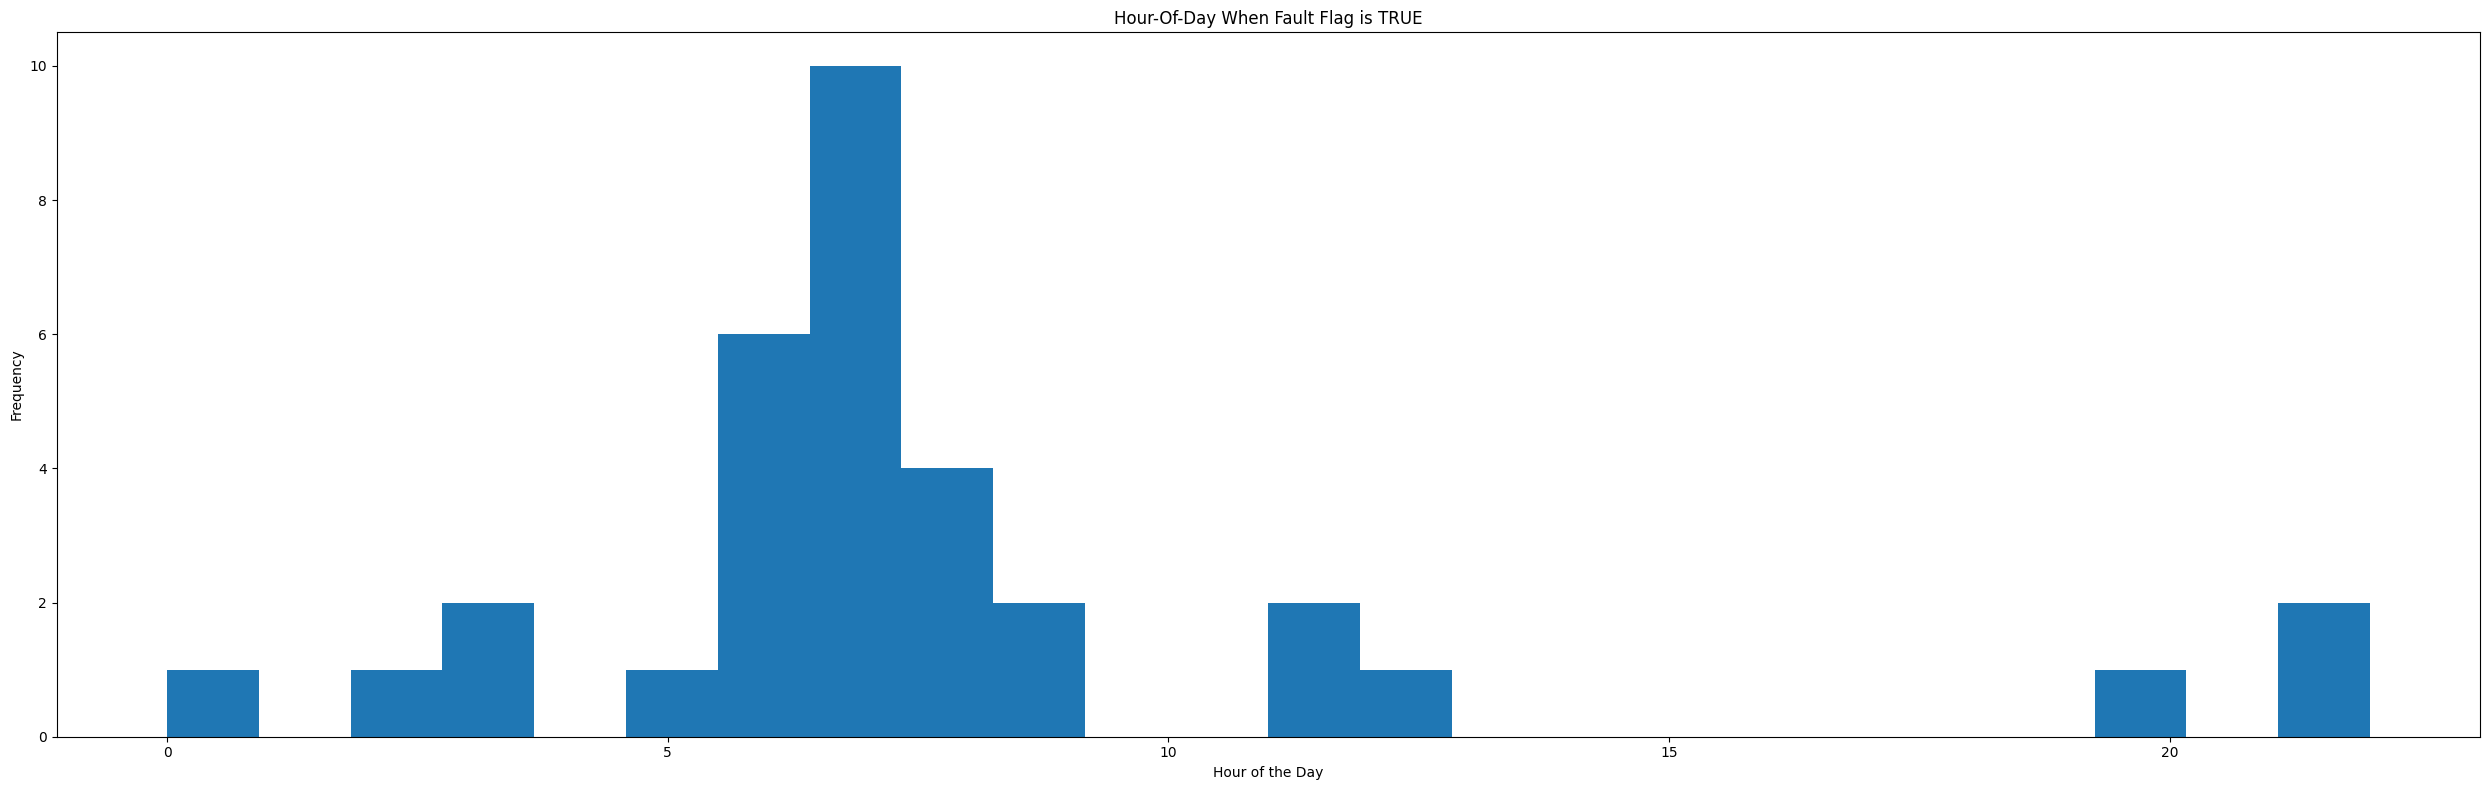

In [23]:
from open_fdd.air_handling_unit.reports.report_fc4 import FaultCodeFourReport

# Create an instance of FaultCodeFourReport
fc4_report = FaultCodeFourReport(config_dict)
fc4_report.display_report_in_ipython(df_fc4)

I’ve configured my dictionary with `'DELTA_OS_MAX': 3`, meaning it will flag instances where there are 3 operating state changes per hour. ASHRAE, I believe, recommends a default setting of 7 OS changes per hour, which seems quite high to me, but this is open for discussion. Additionally, the histogram plot generated by the open-fdd report (which automatically triggers if a flag is raised) highlights potential faults occurring in the morning—possibly due to morning warmups for the building. In colder climates, this could place significant demand on the boiler plant, and if the PID tuning is poor, it might lead to issues.

### Fault Condition 5: SAT Too Low in Heating Mode
$$
\text{SAT} + \text{eSAT} \leq \text{MAT} - \text{eMAT} + \Delta T_{\text{fan}} \quad \text{and} \quad \text{Heating\_Sig} > 0.01 \quad \text{and} \quad \text{VFDSPD} > 0.01
$$

In the plots below I have a feeling the AHU transitions between heating and economizing free cooling in the Winter too much.

Fault Condition 5: Supply air temperature too low; should be higher than mix air


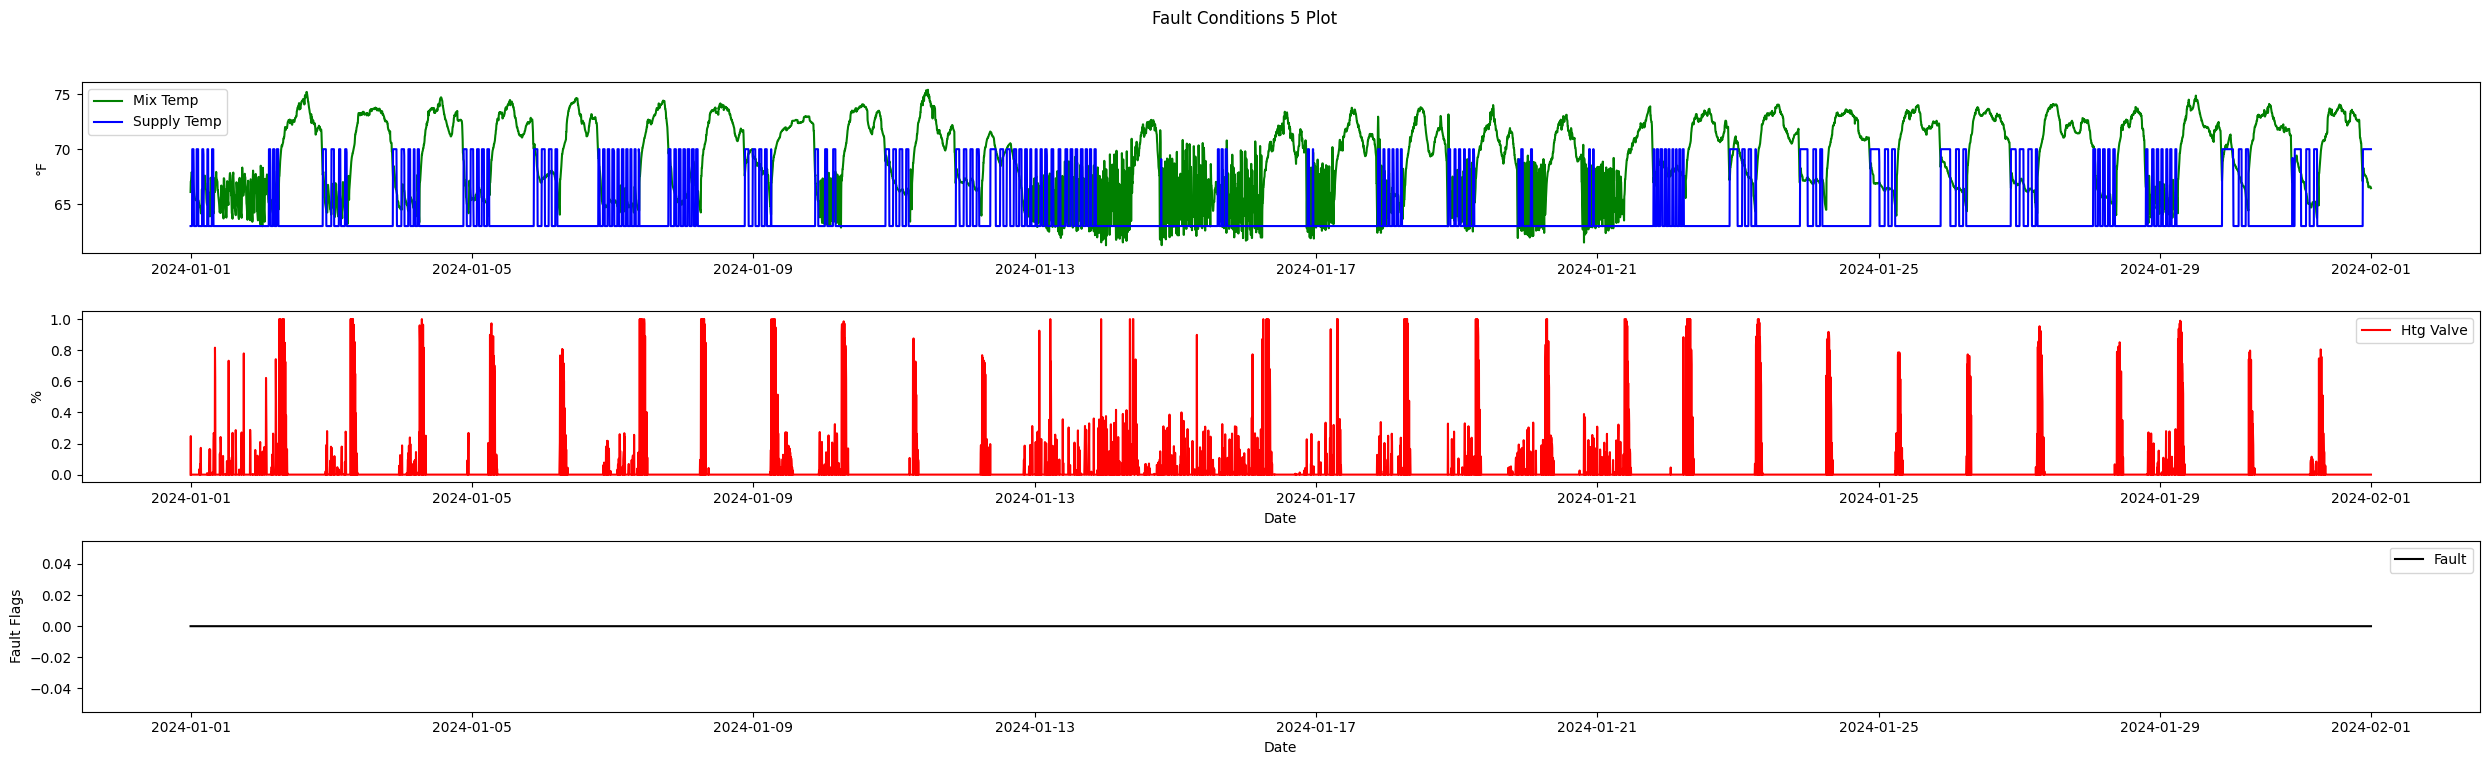

total days: 31.0
total hours: 744
hours fc5 mode: 0
percent true: 0.0
percent false: 100.0
flag true mat: nan
flag true sat: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [24]:
from open_fdd.air_handling_unit.reports.report_fc5 import FaultCodeFiveReport

# Create an instance of FaultCodeFourReport
fc5_report = FaultCodeFiveReport(config_dict)
fc5_report.display_report_in_ipython(df_combined)

Fault condition 6 is skipped because there no fan or totalized VAV system air flow stations.

### Fault Condition 7: SAT Too Low in Full Heating
$$
\text{SAT} < \text{SAT\_SP} - \text{eSAT} \quad \text{and} \quad \text{Heating\_Sig} > 0.9 \quad \text{and} \quad \text{VFDSPD} > 0
$$

Fault Condition 7: Supply air temperature too low in full heating mode


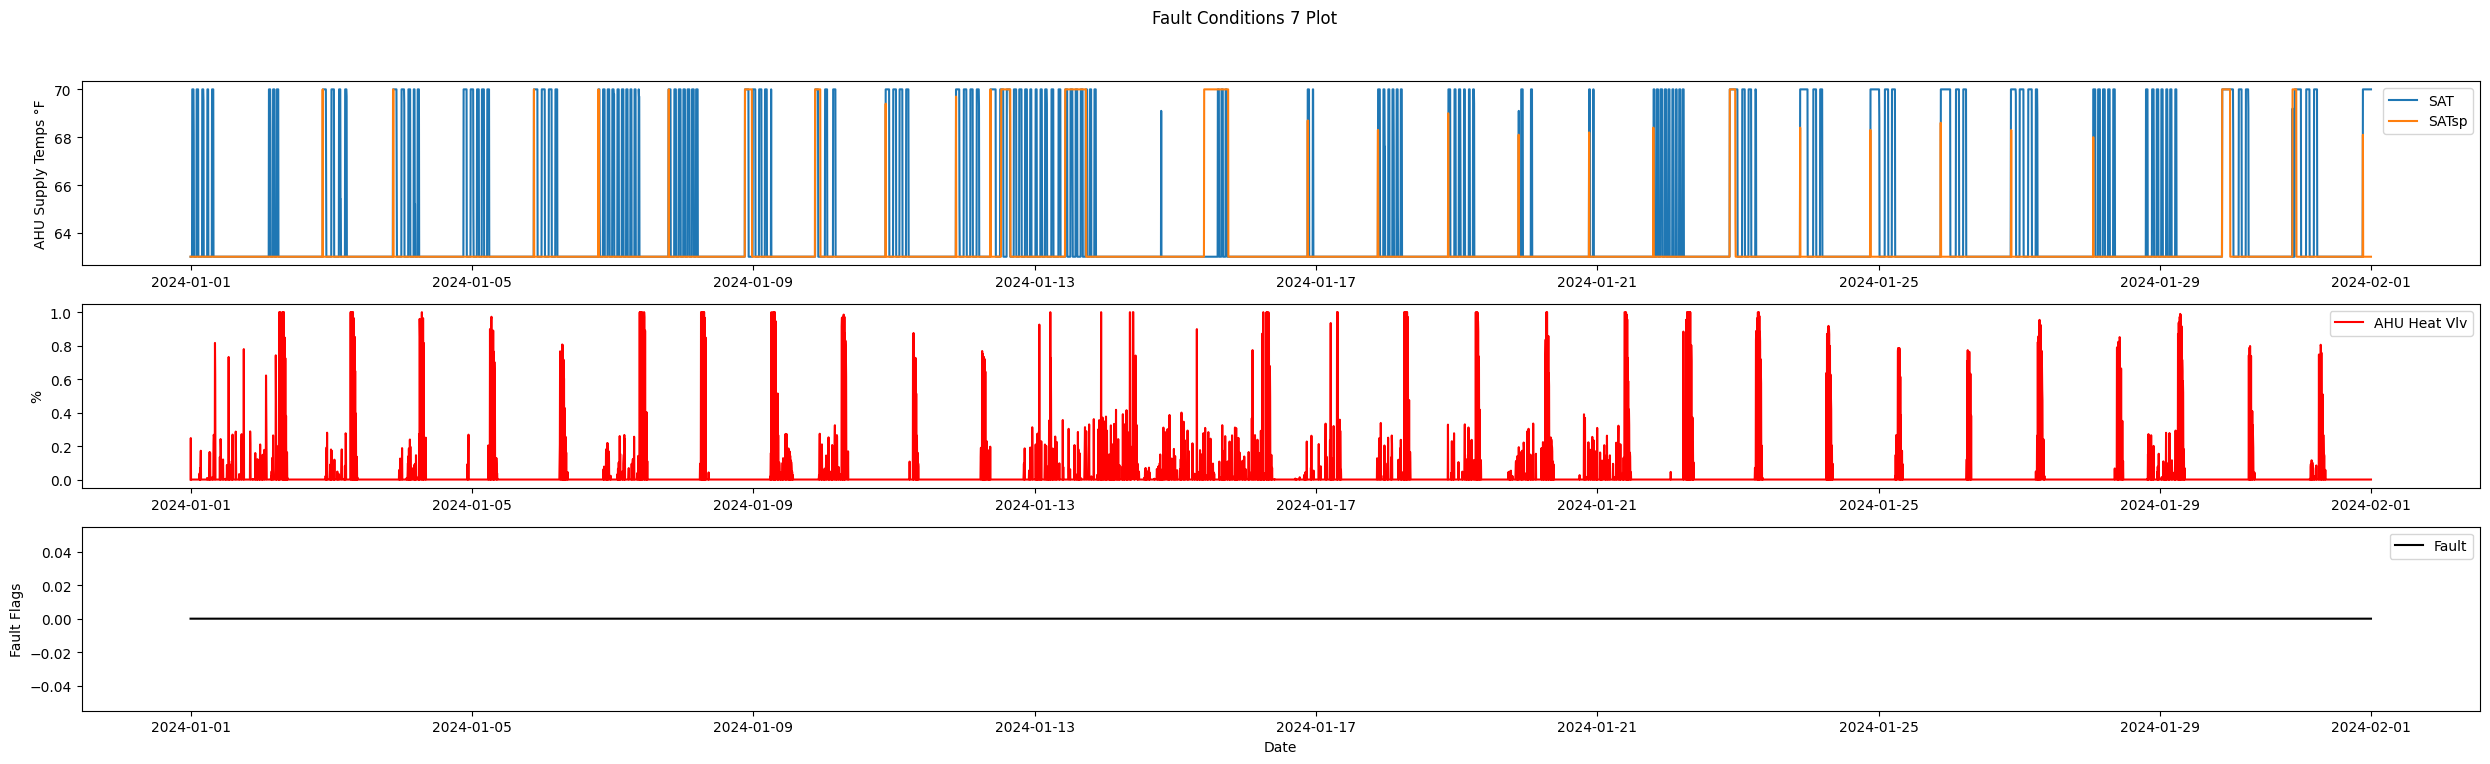

total days: 31.0
total hours: 744
hours fc7 mode: 0
percent true: 0.0
percent false: 100.0
flag true satsp: nan
flag true sat: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [25]:
from open_fdd.air_handling_unit.reports.report_fc7 import FaultCodeSevenReport

# Create an instance of FaultCodeFourReport
fc7_report = FaultCodeSevenReport(config_dict)
fc7_report.display_report_in_ipython(df_combined)


In `fc8` below there is an aweful amount faults where some tuning could happen on the `config dict`. ASHRAEs and NIST fault equation calls for the supply air temperature and mixing to be approximetely equal. 

```python
    'OUTDOOR_DEGF_ERR_THRES': 5.0,
    'MIX_DEGF_ERR_THRES': 5.0,
    'RETURN_DEGF_ERR_THRES': 2.0,
    'SUPPLY_DEGF_ERR_THRES': 2.0,

```

Those tuning parameters due seem legit. See the fault equation code for more detail. 

https://github.com/bbartling/open-fdd/blob/master/open_fdd/air_handling_unit/faults/fault_condition_eight.py

In my opinion, these are likely false positives, but the AHU shouldn't be economizing throughout the entire winter either. It's possible that the AHU is programmed to control the mixed air temperature, preventing the mix chamber from getting too cold. This might cause the AHU to cool slightly during winter, leading to numerous false positives. However, I believe there's still an unresolved issue with winter economizing that warrants further investigation.

Another thing that looks odd is the faults should be filtered for when the AHU is running where it seems like a lot of faults occur when the AHU is possibily not running which could warrant more investigation.

### Fault Condition 8: SAT and MAT Should Be Approximately Equal in Economizer Mode

$$
|\text{SAT} - \Delta T_{\text{fan}} - \text{MAT}| > \sqrt{\text{eSAT}^2 + \text{eMAT}^2} \quad \text{and} \quad \text{Economizer} > \text{MinOA} \quad \text{and} \quad \text{Cooling} < 0.1
$$

Fault Condition 8: Supply air temperature and mix air temperature should be approximately equal in economizer mode


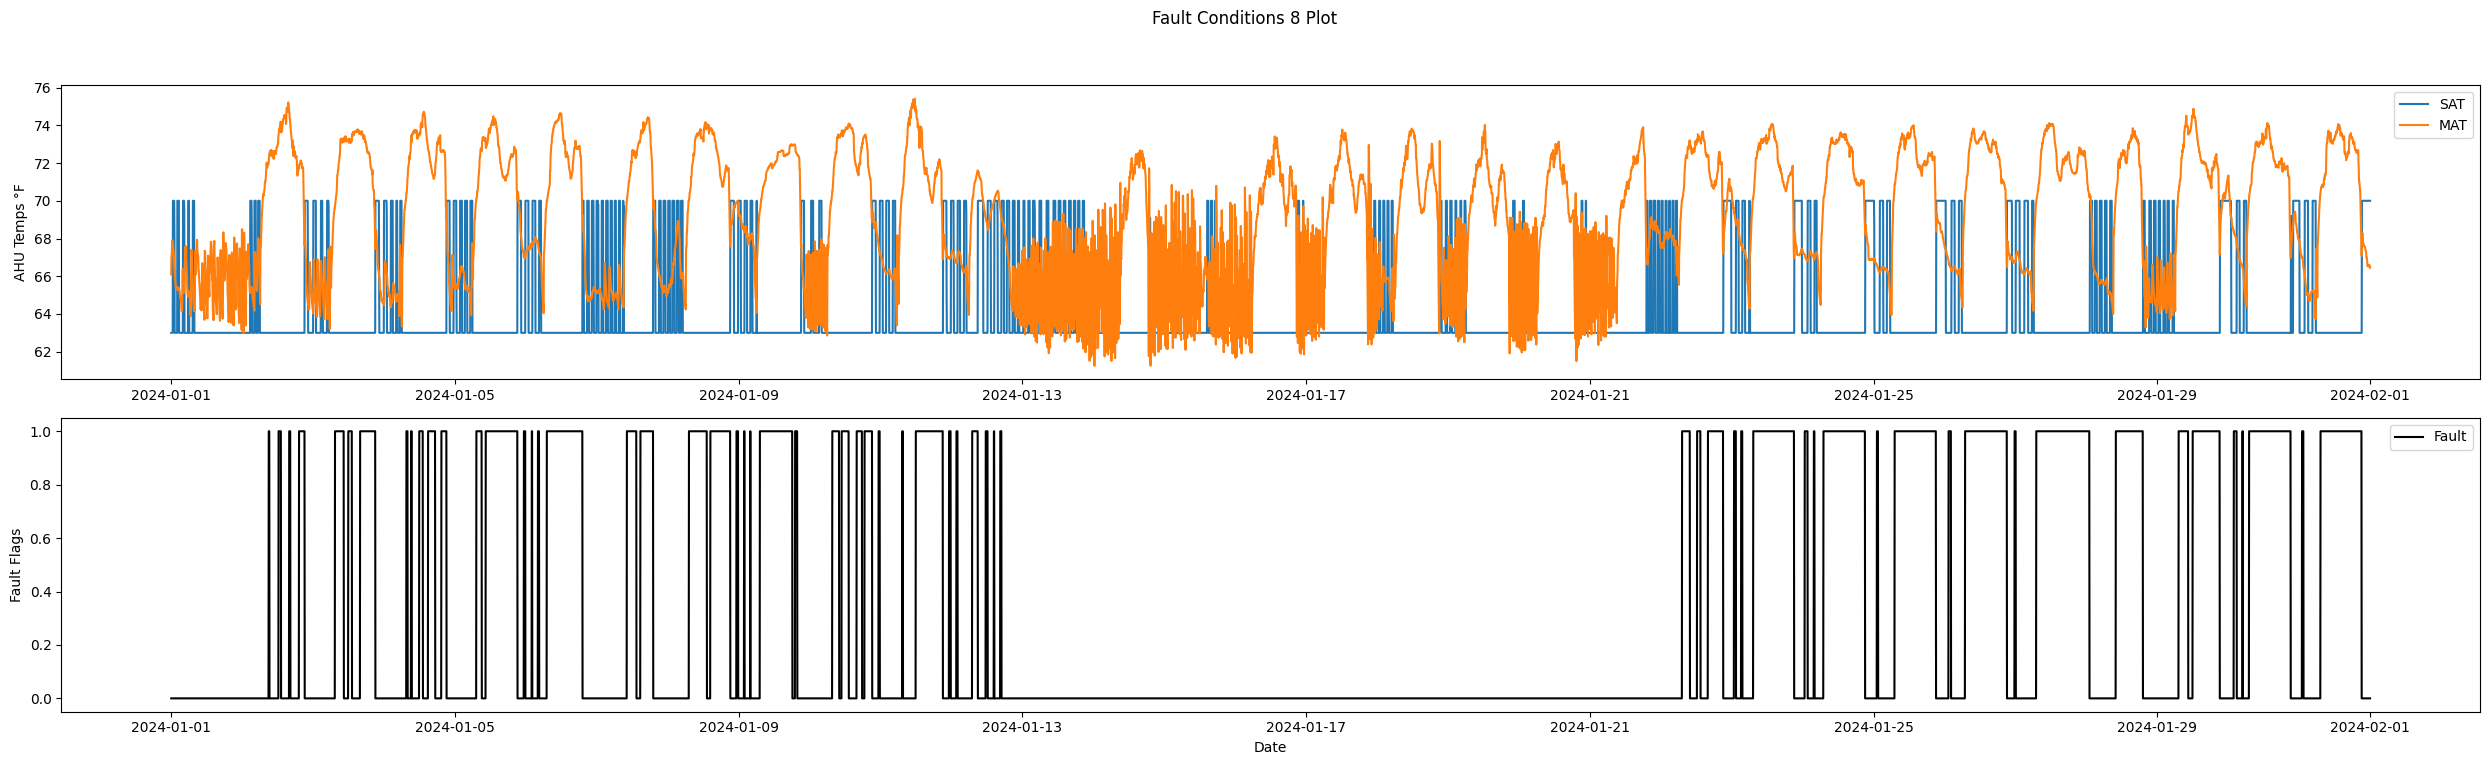

total days: 31.0
total hours: 744
hours fc8 mode: 239
percent true: 32.15
percent false: 67.85
flag true mat: 72.13
flag true sat: 63.0
hours motor runtime: 669.0
Fault Flag Count:  1


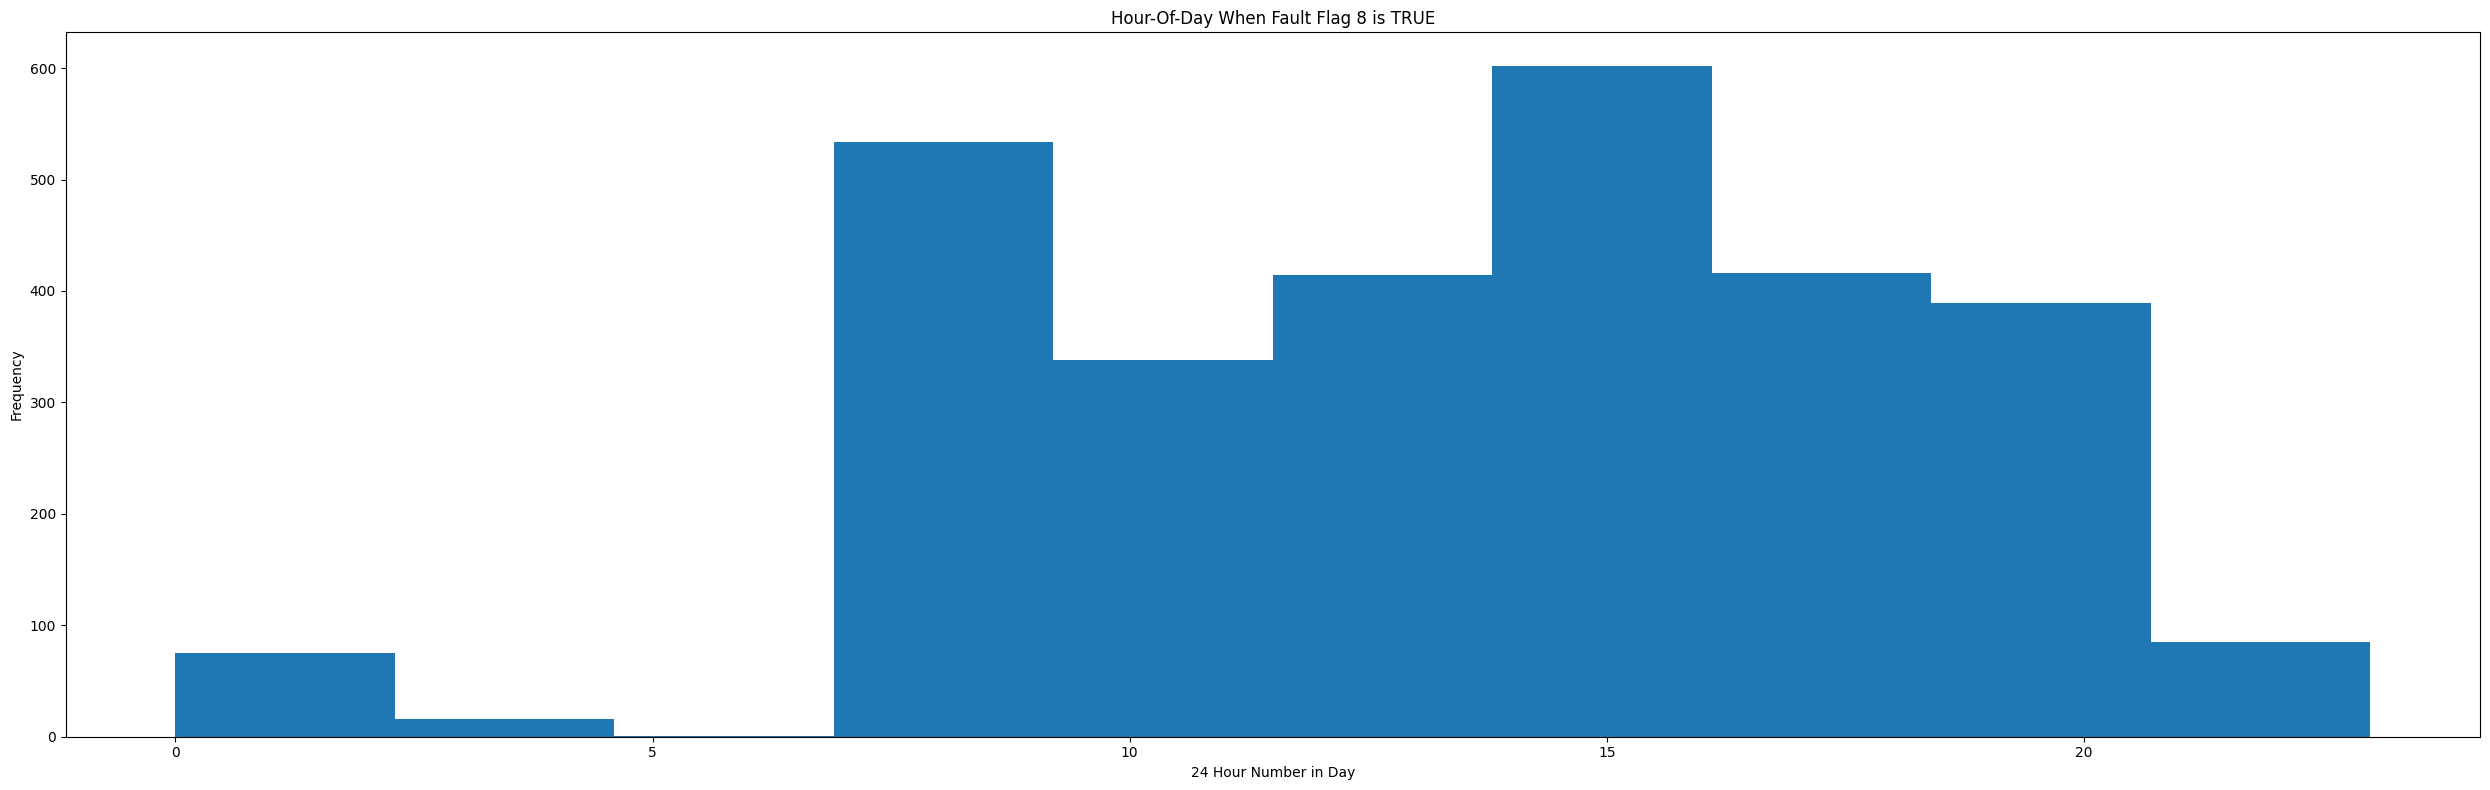

Mix Air Temp Mean When In Fault:  72.13
Supply Air Temp Mean When In Fault:  63.0
The percent True metric that represents the amount of time for when the fault flag is True is high indicating temperature sensor error or the heating/cooling coils are leaking, potentially creating simultaneous heating/cooling which can be an energy penalty for running the AHU in this fashion. Verify AHU mix/supply temperature sensor calibration in addition to a potential mechanical issue of a leaking valve. A leaking valve can be troubleshot by isolating the valve closed by manual shut-off valves where piping lines enter the AHU coil and then verifying any changes in the AHU discharge air temperature.


In [26]:
from open_fdd.air_handling_unit.reports.report_fc8 import FaultCodeEightReport

# Create an instance of FaultCodeFourReport
fc8_report = FaultCodeEightReport(config_dict)
fc8_report.display_report_in_ipython(df_combined)

Its interesting in the histogram above of the time-of-day that the faults occur more in the afternoons which could indicate building over heats in the Winter afternoons and cooling is needed?

### Fault Condition 9: OAT Too High in Free Cooling Mode
$$
\text{OAT} - \text{eOAT} > \text{SAT\_SP} - \Delta T_{\text{fan}} + \text{eSAT} \quad \text{and} \quad \text{Economizer} > \text{MinOA} \quad \text{and} \quad \text{Cooling} < 0.1
$$


Fault Condition 9: Outside air temperature too high in free cooling without additional mechanical cooling in economizer mode


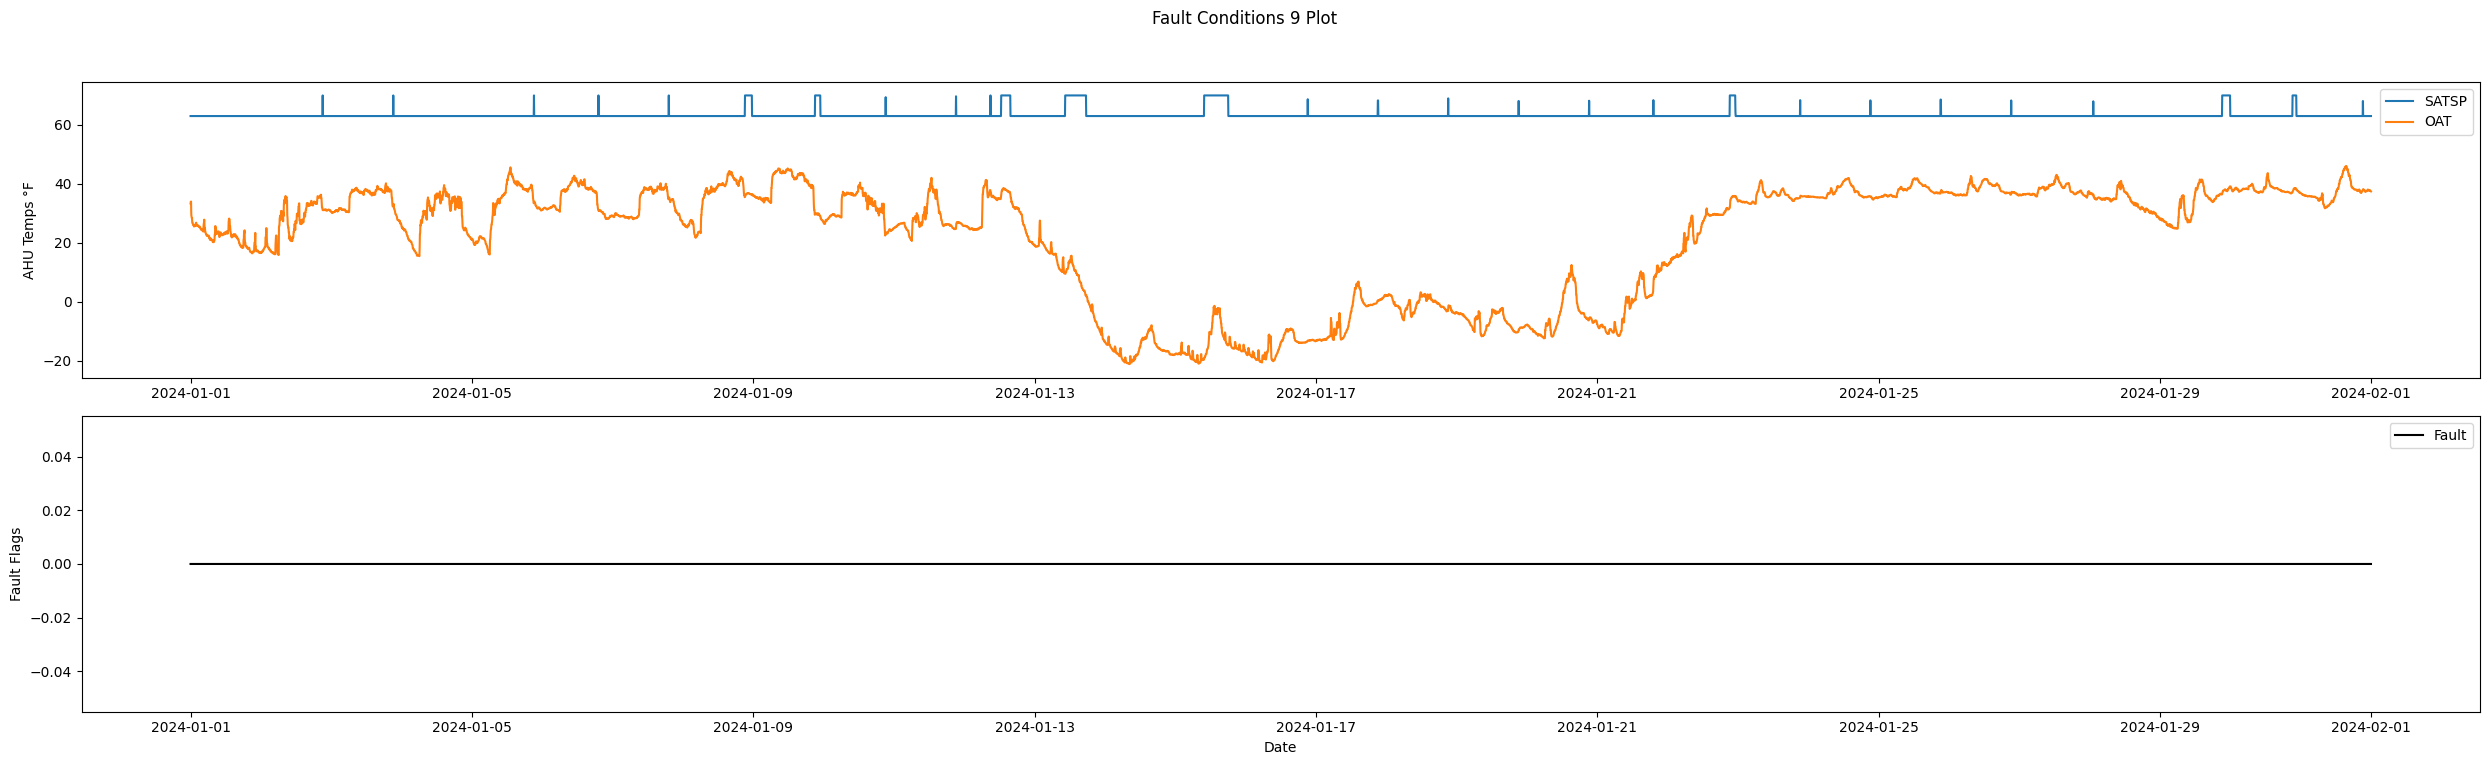

total days: 31.0
total hours: 744
hours fc9 mode: 0
percent true: 0.0
percent false: 100.0
flag true oat: nan
flag true satsp: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [27]:
from open_fdd.air_handling_unit.reports.report_fc9 import FaultCodeNineReport

# Create an instance of FaultCodeFourReport
fc9_report = FaultCodeNineReport(config_dict)
fc9_report.display_report_in_ipython(df_combined)

### Fault Condition 10: OAT and MAT Should Be Approximately Equal in Economizer Plus Mechanical Cooling Mode
$$
|\text{MAT} - \text{OAT}| > \sqrt{\text{eMAT}^2 + \text{eOAT}^2} \quad \text{and} \quad \text{Cooling\_Sig} > 0.01 \quad \text{and} \quad \text{Economizer\_Sig} > 0.9
$$

Fault Condition 10: Outdoor air temperature and mix air temperature should be approximately equal in economizer plus mech cooling mode


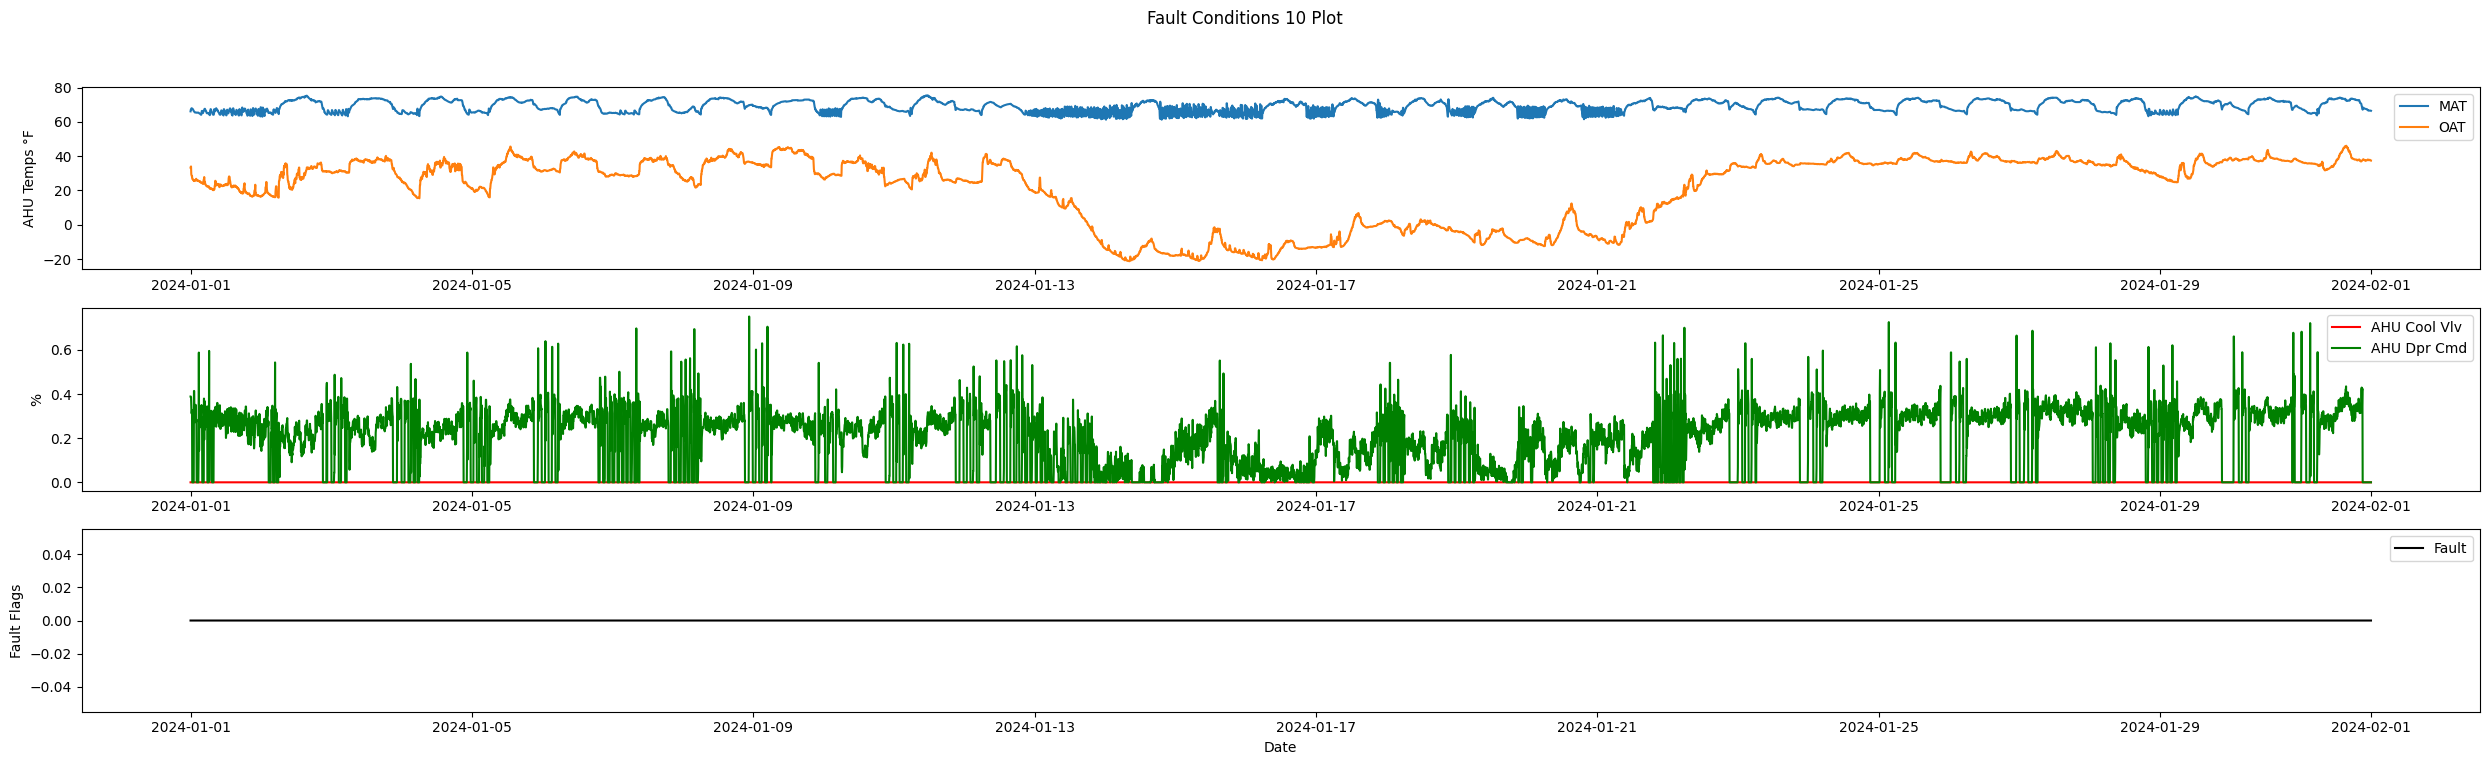

total days: 31.0
total hours: 744
hours fc10 mode: 0
percent true: 0.0
percent false: 100.0
flag true oat: nan
flag true mat: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [28]:
from open_fdd.air_handling_unit.reports.report_fc10 import FaultCodeTenReport

# Create an instance of FaultCodeFourReport
fc10_report = FaultCodeTenReport(config_dict)
fc10_report.display_report_in_ipython(df_combined)

### Fault Condition 11: OAT Too Low for 100% OA Cooling in Economizer Mode
$$
\text{OAT} + \text{eOAT} < \text{SAT\_SP} - \Delta T_{\text{fan}} - \text{eSAT} \quad \text{and} \quad \text{Cooling\_Sig} > 0.01 \quad \text{and} \quad \text{Economizer\_Sig} > 0.9
$$

Fault Condition 11: Outside air temperature too low for 100% outside air cooling in economizer mode


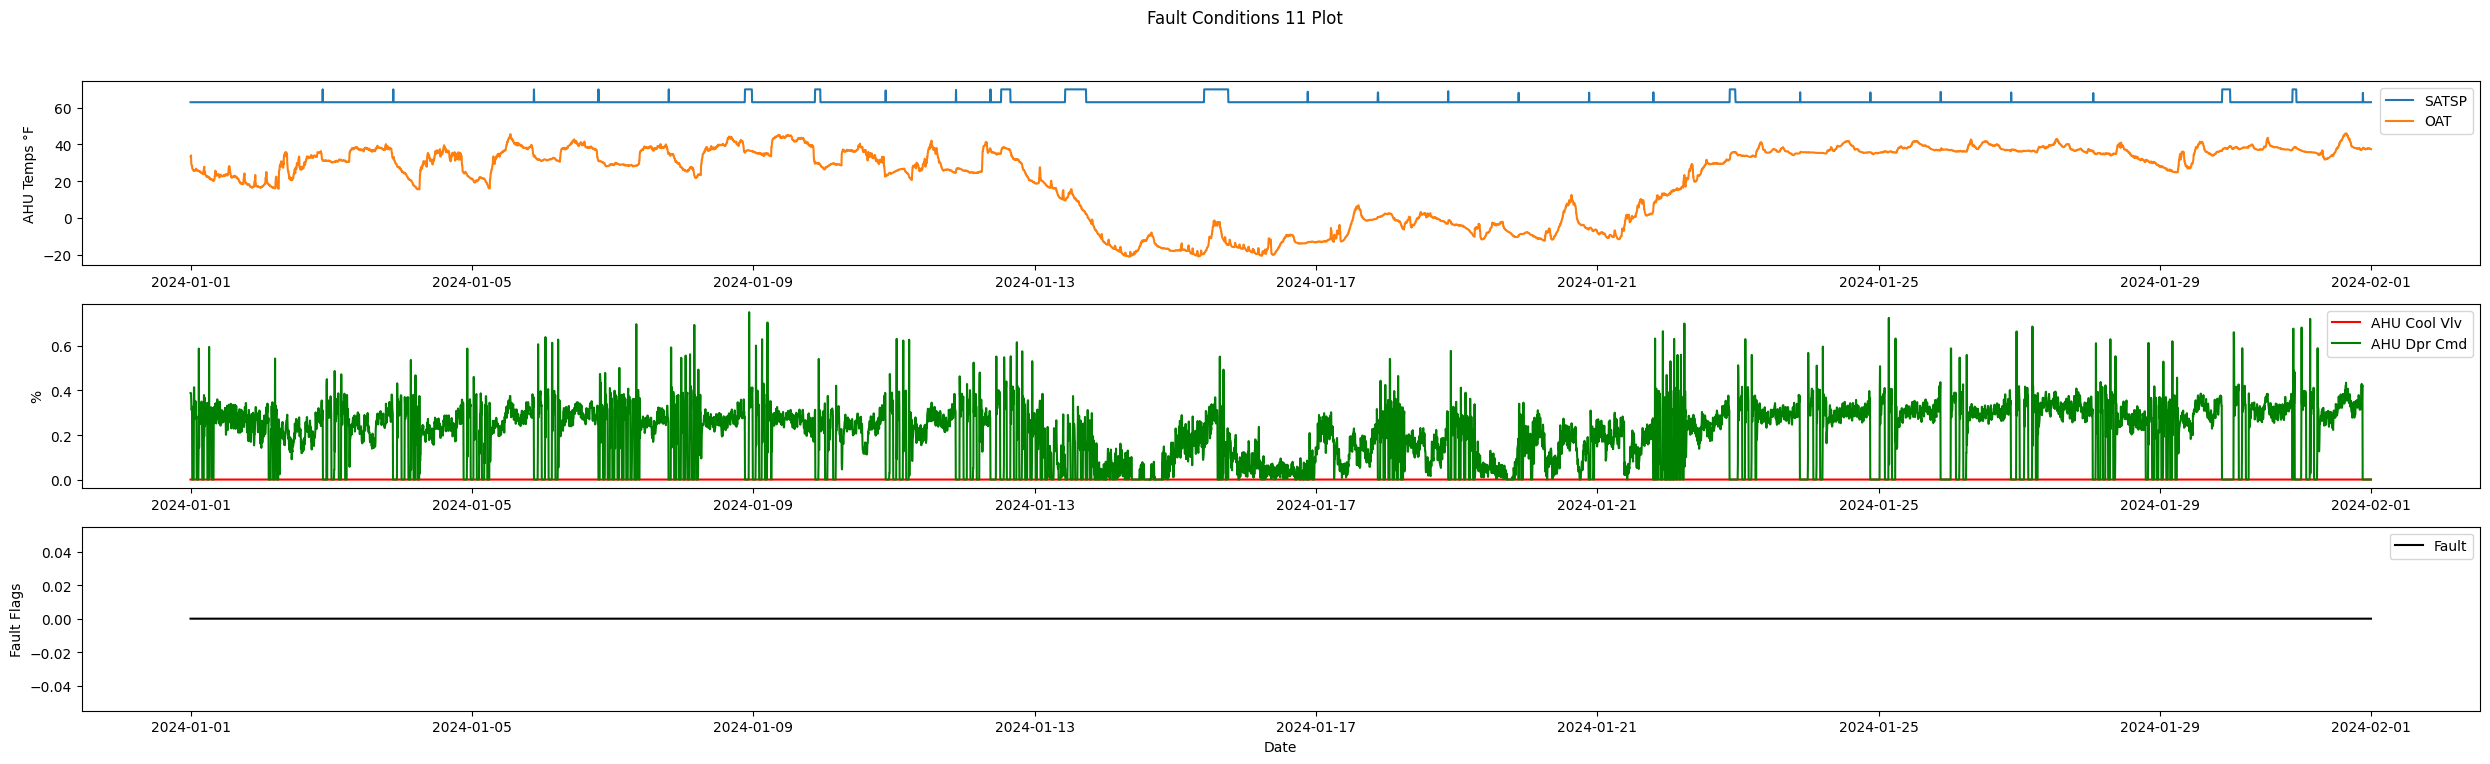

total days: 31.0
total hours: 744
hours fc11 mode: 0
percent true: 0.0
percent false: 100.0
flag true oat: nan
flag true sat sp: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [29]:
from open_fdd.air_handling_unit.reports.report_fc11 import FaultCodeElevenReport

# Create an instance of FaultCodeFourReport
fc11_report = FaultCodeElevenReport(config_dict)
fc11_report.display_report_in_ipython(df_combined)

### Fault Condition 12: SAT Too High, Should Be Less Than MAT in Economizer Plus Mechanical Cooling Mode
$$
\text{SAT} - \text{eSAT} - \Delta T_{\text{fan}} > \text{MAT} + \text{eMAT} \quad \text{and} \quad \left(\text{Cooling\_Sig} > 0.01 \quad \text{and} \quad \text{Economizer\_Sig} = \text{Min\_OA\_DPR}\right) \quad \text{or} \quad \left(\text{Cooling\_Sig} > 0.01 \quad \text{and} \quad \text{Economizer\_Sig} > 0.9\right)
$$

Fault Condition 12: Supply air temperature too high; should be less than mix air temperature in economizer plus mech cooling mode


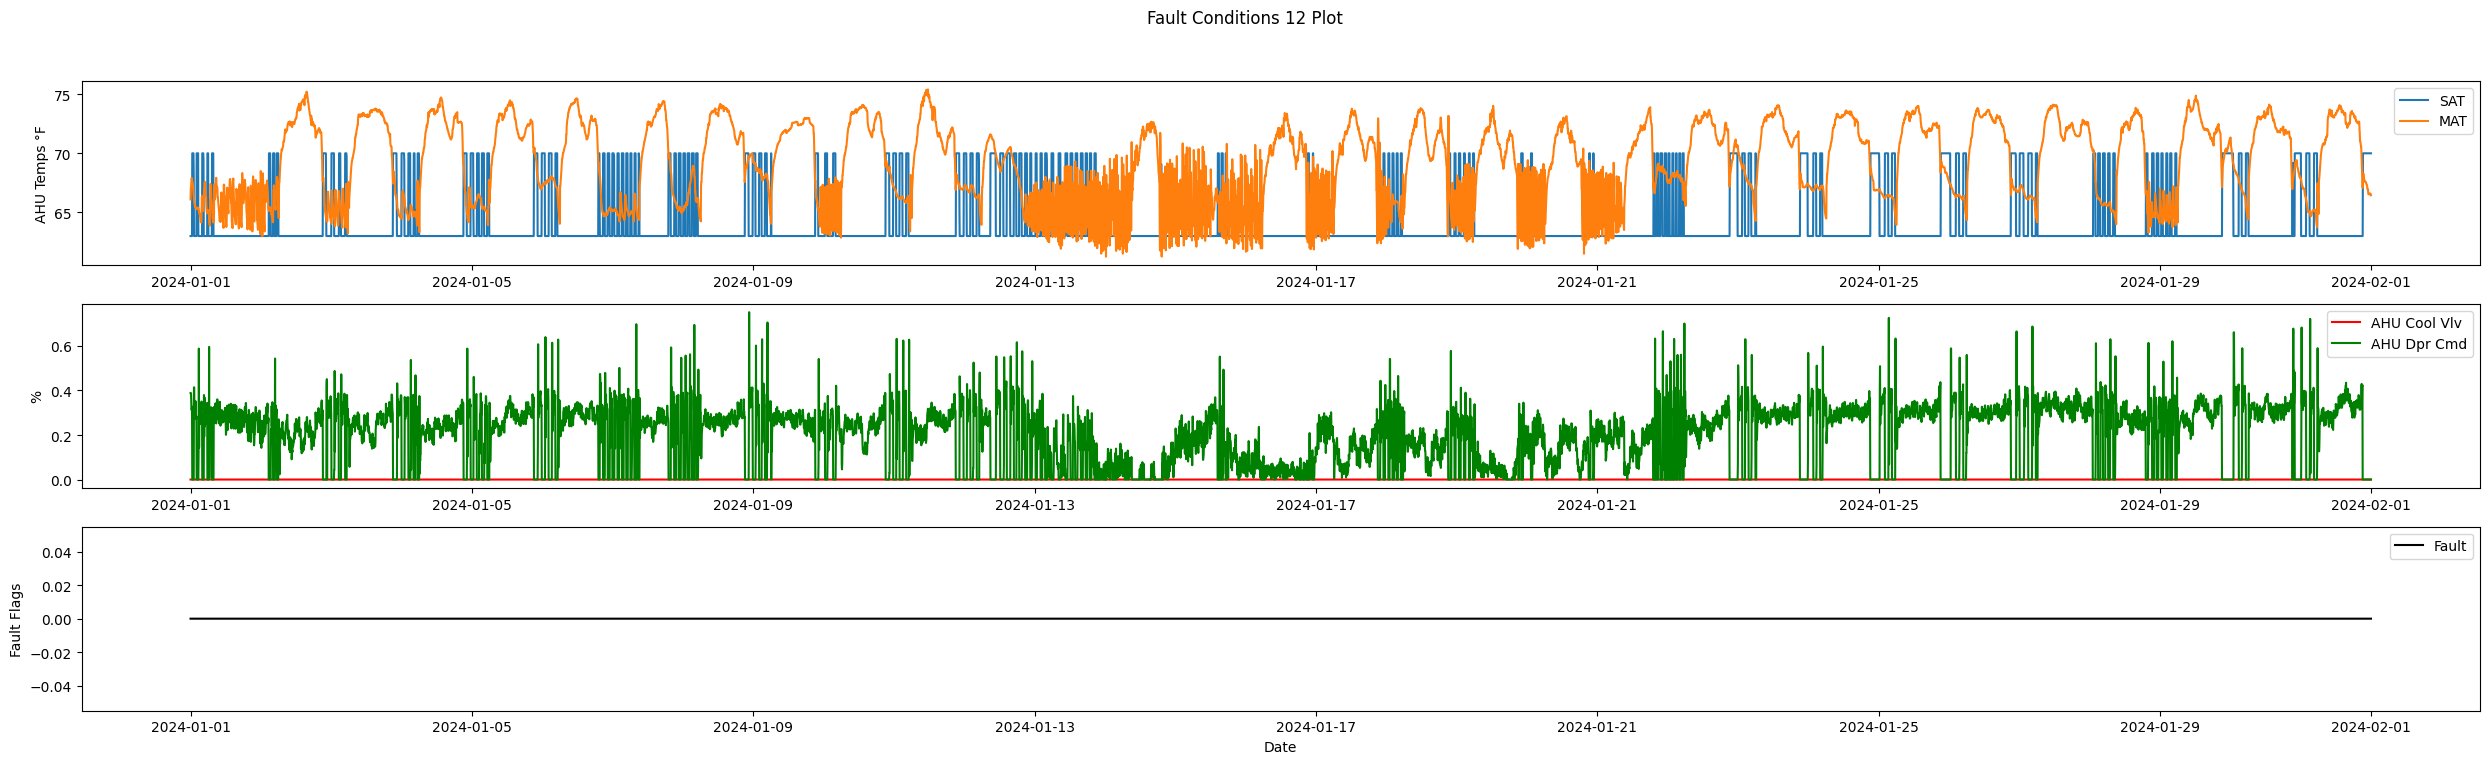

total days: 31.0
total hours: 744
hours fc12 mode: 0
percent true: 0.0
percent false: 100.0
flag true mat: nan
flag true sat: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [30]:
from open_fdd.air_handling_unit.reports.report_fc12 import FaultCodeTwelveReport

# Create an instance of FaultCodeFourReport
fc12_report = FaultCodeTwelveReport(config_dict)
fc12_report.display_report_in_ipython(df_combined)

### Fault Condition 13: SAT Too High in Full Cooling in Economizer Plus Mechanical Cooling Mode
$$
\text{SAT} > \text{SAT\_SP} + \text{eSAT} \quad \text{and} \quad \left(\text{Cooling\_Sig} > 0.01 \quad \text{and} \quad \text{Economizer\_Sig} = \text{Min\_OA\_DPR}\right) \quad \text{or} \quad \left(\text{Cooling\_Sig} > 0.01 \quad \text{and} \quad \text{Economizer\_Sig} > 0.9\right)
$$

Fault Condition 13: Supply air temperature too high in full cooling in economizer plus mech cooling mode


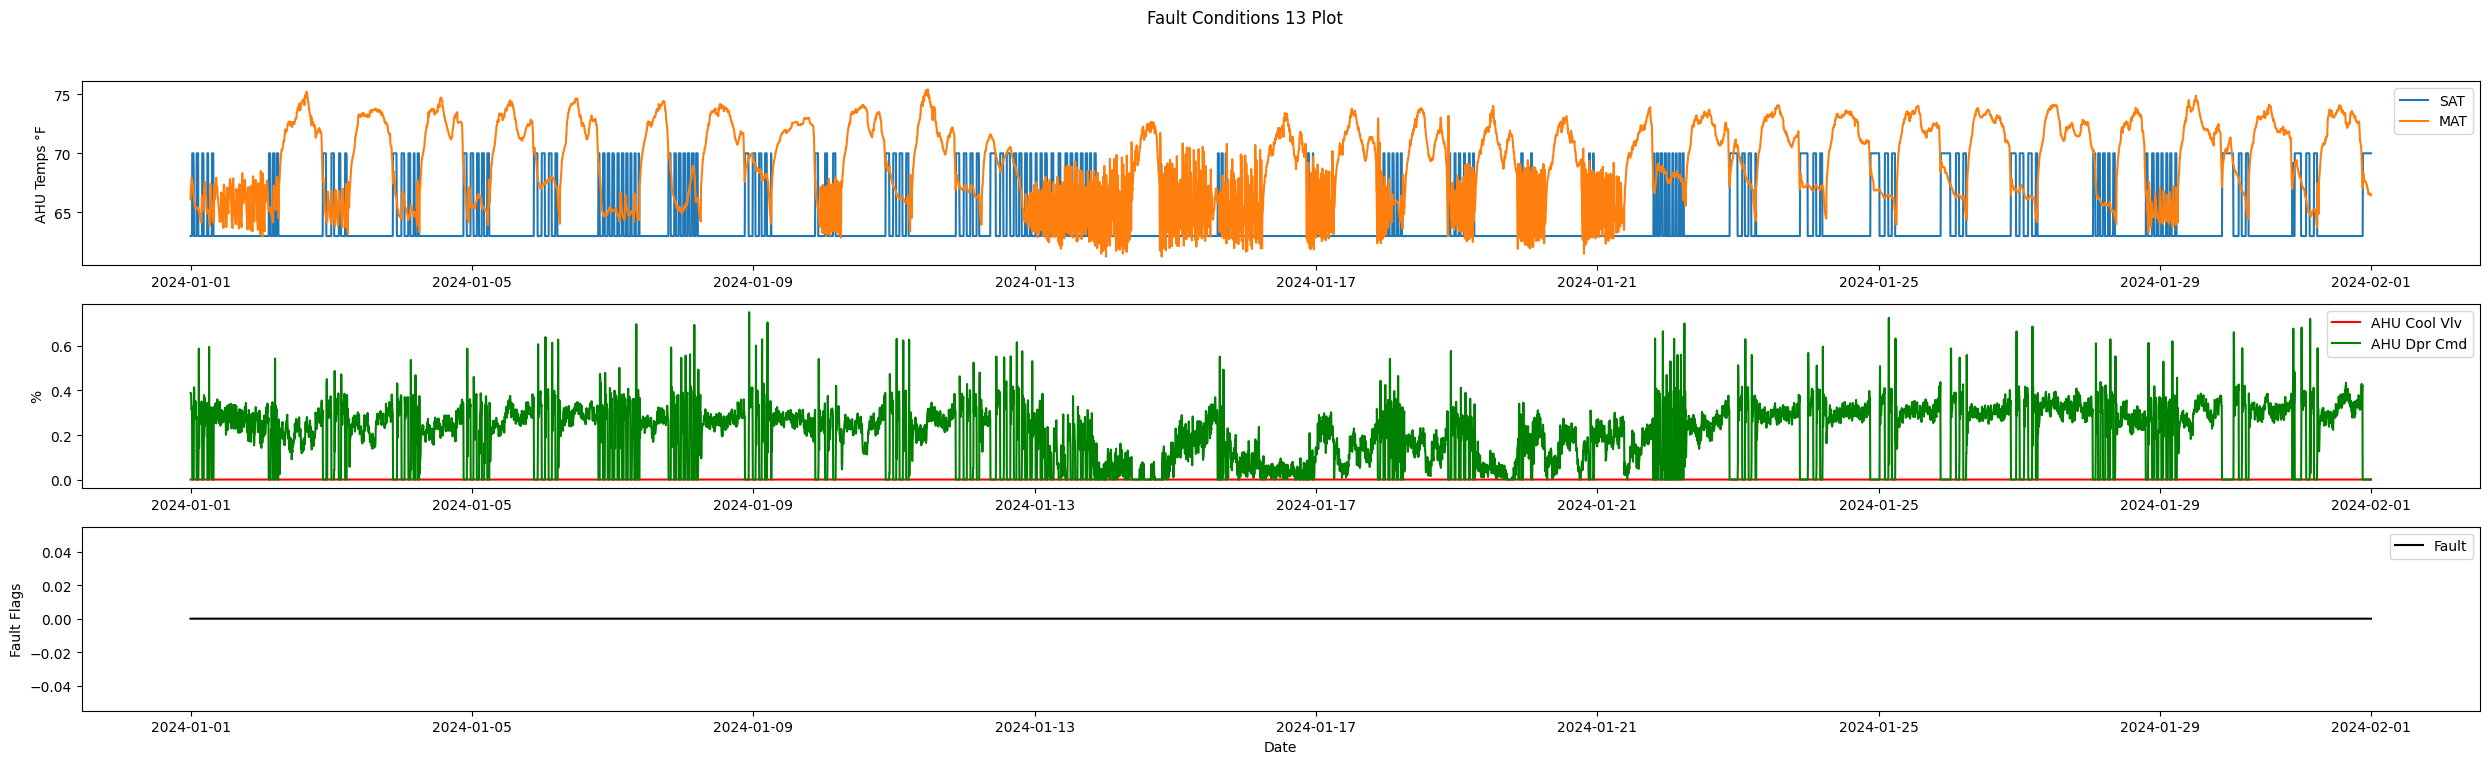

total days: 31.0
total hours: 744
hours fc13 mode: 0
percent true: 0.0
percent false: 100.0
flag true mat: nan
flag true sat: nan
hours motor runtime: 669.0
Fault Flag Count:  0
NO FAULTS FOUND - Skipping time-of-day Histogram plot


In [31]:
from open_fdd.air_handling_unit.reports.report_fc13 import FaultCodeThirteenReport

# Create an instance of FaultCodeFourReport
fc13_report = FaultCodeThirteenReport(config_dict)
fc13_report.display_report_in_ipython(df_combined)

It seems like the mixing air dampers show alot of action for a cold Winter month of January.

<Axes: xlabel='timestamp'>

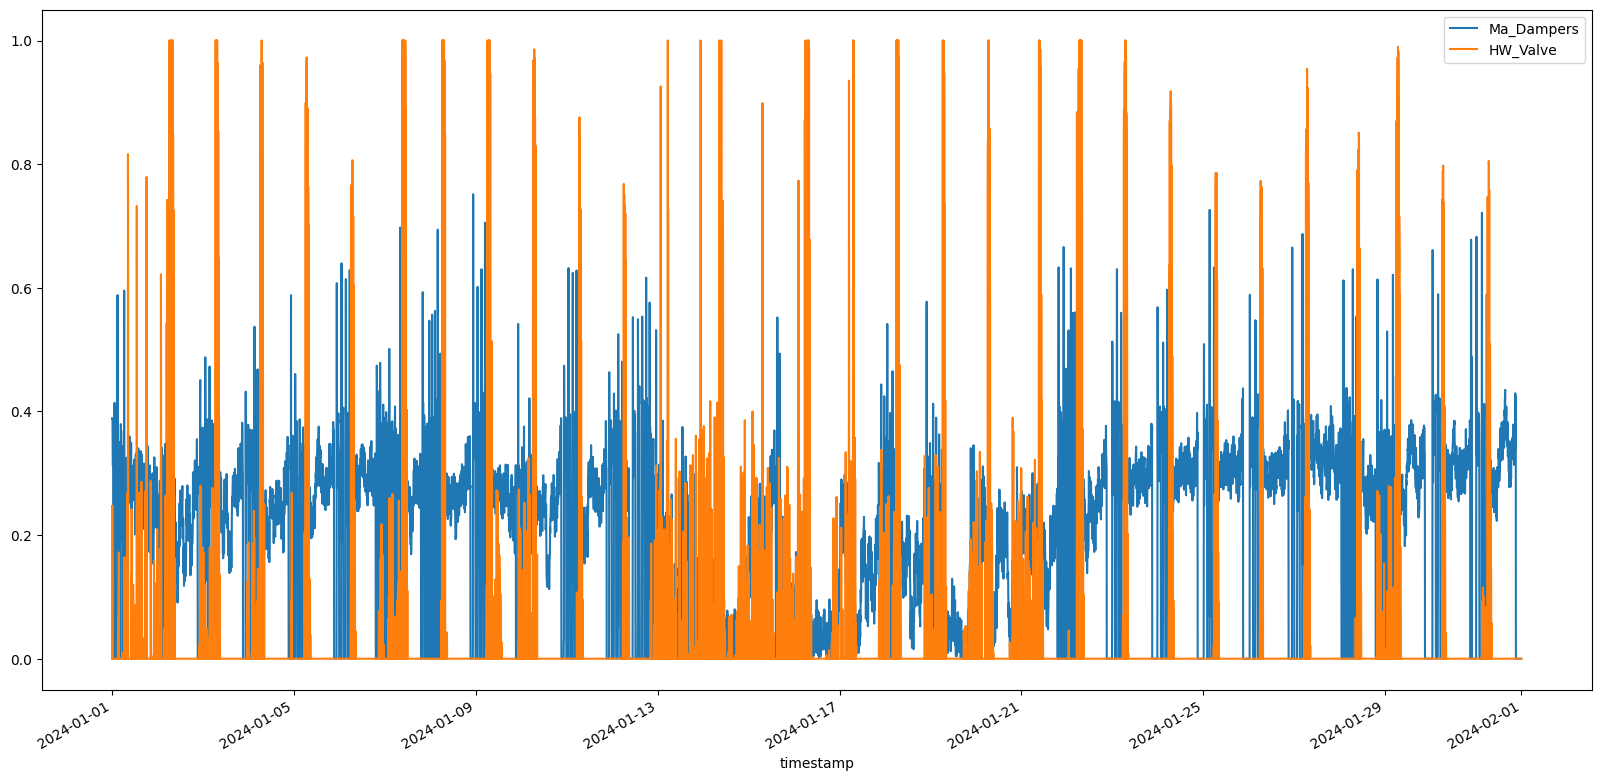

In [32]:
df_combined[['Ma_Dampers', 'HW_Valve']].plot(figsize=(20, 10))

This is some custom plotting code to see a couple random days. Remember the Y-axis is percent command from 0.0 to 1.0.

Well this is concerning—it seems the heating valve ramps open far too quickly, likely causing the outside air damper to compensate by cooling the discharge air, possibly leading to a hunting issue. Who knows how long this building has been experiencing these problems? It's likely that these small actuator motors have been in constant motion for years, potentially leading to premature burnout. This is a common startup issue in buildings, and many may be facing similar problems, which are difficult to detect in real-time unless they result in temperature control or mechanical failures.

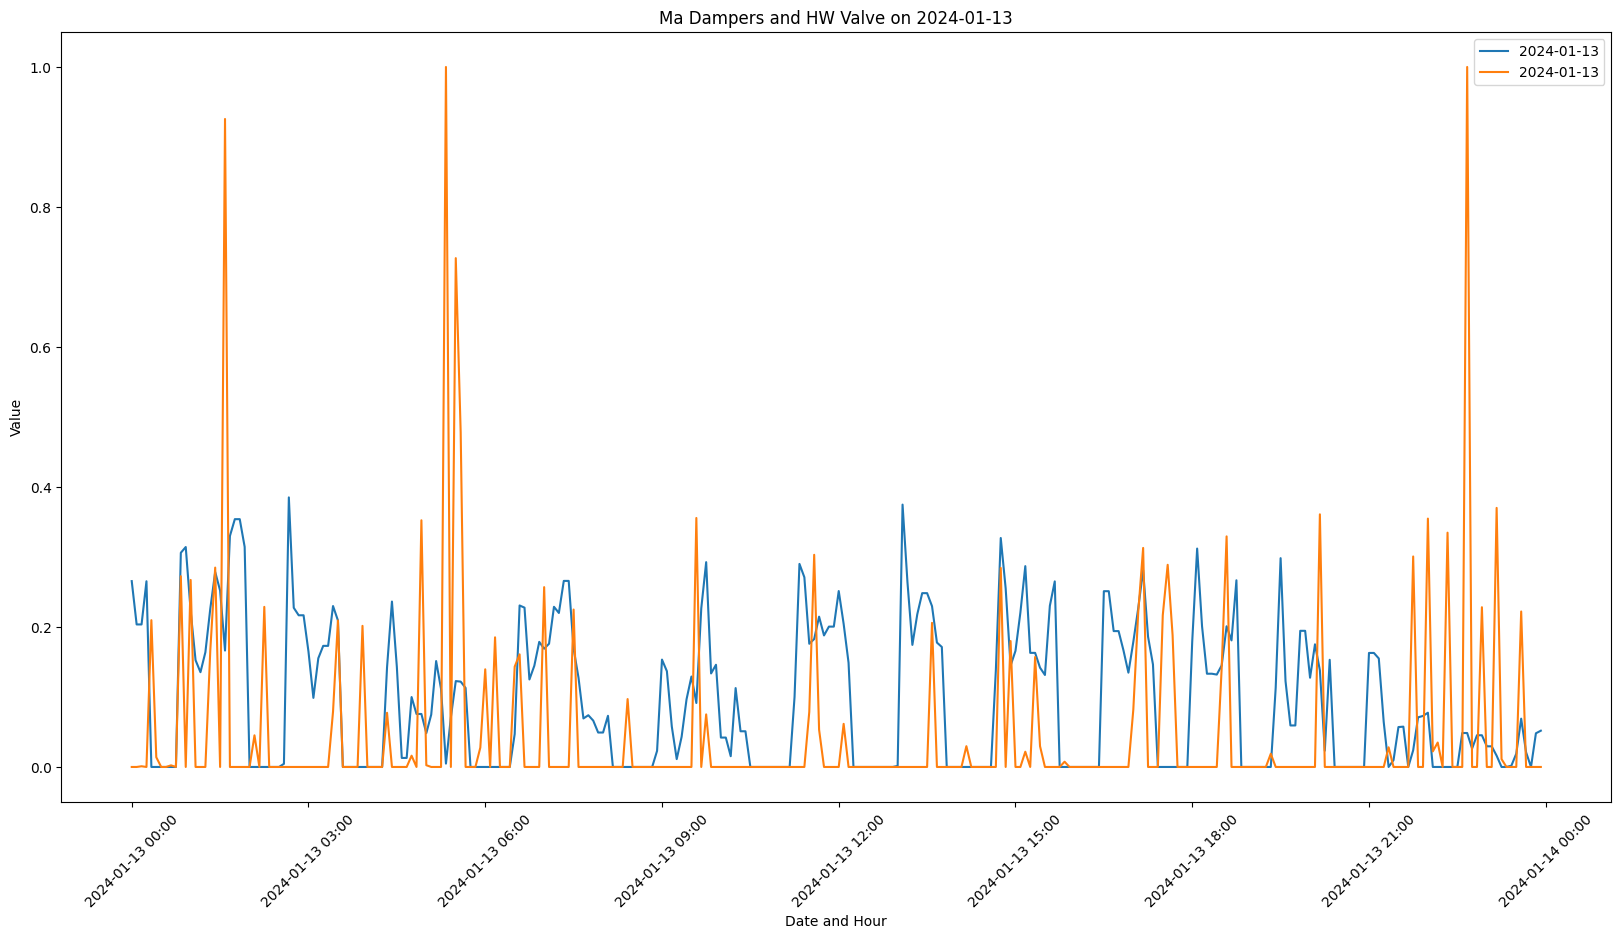

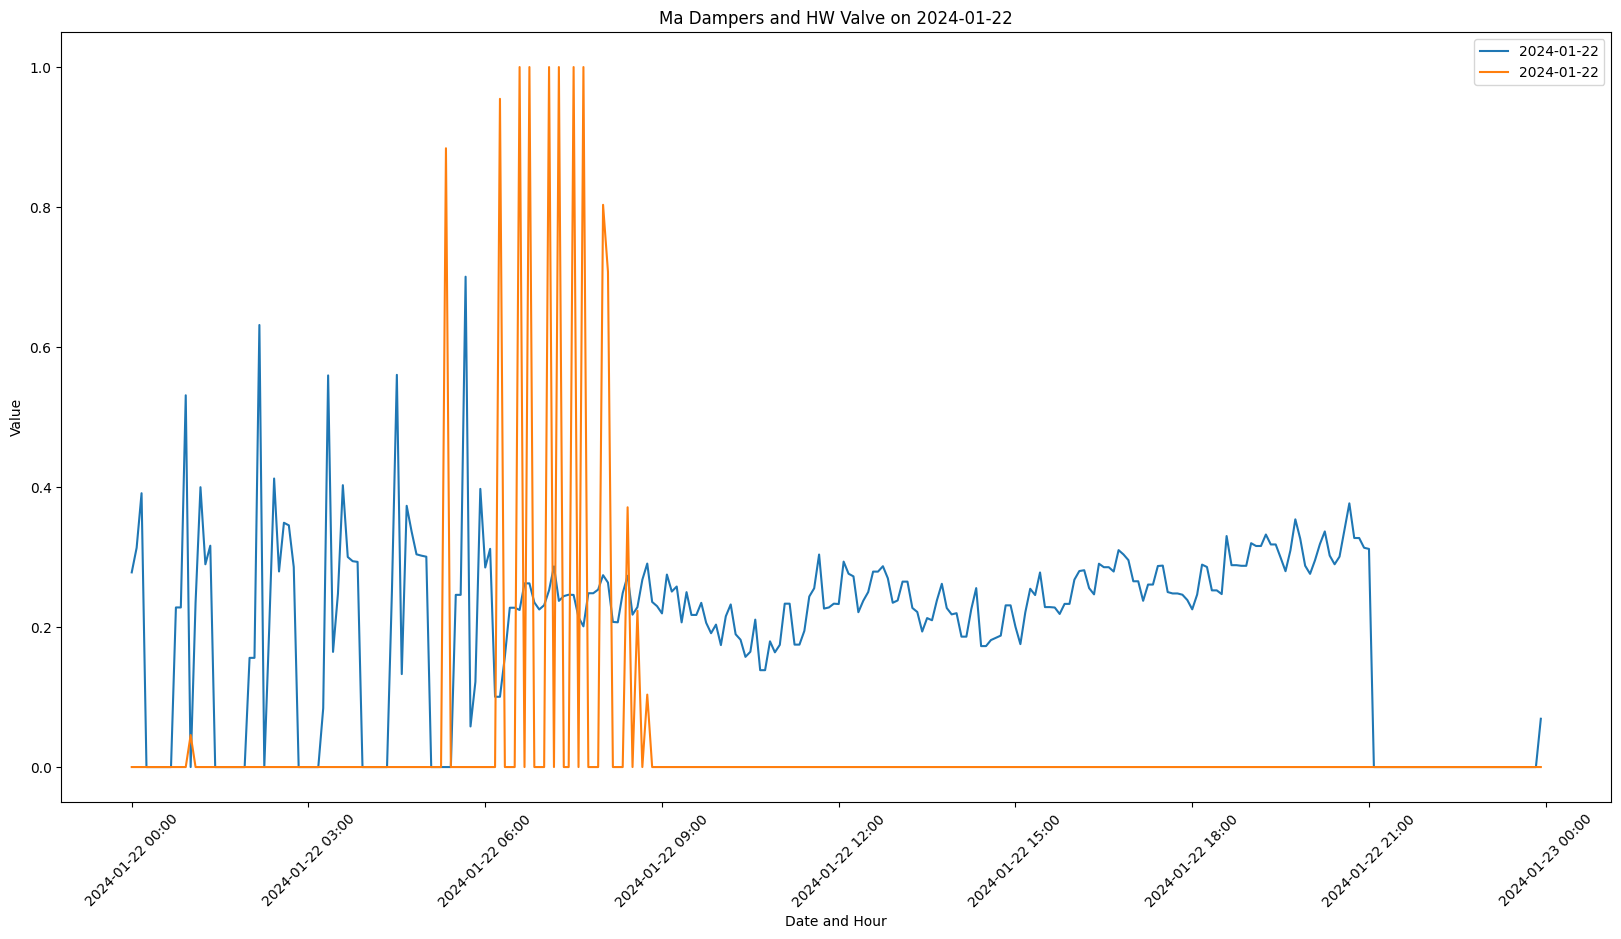

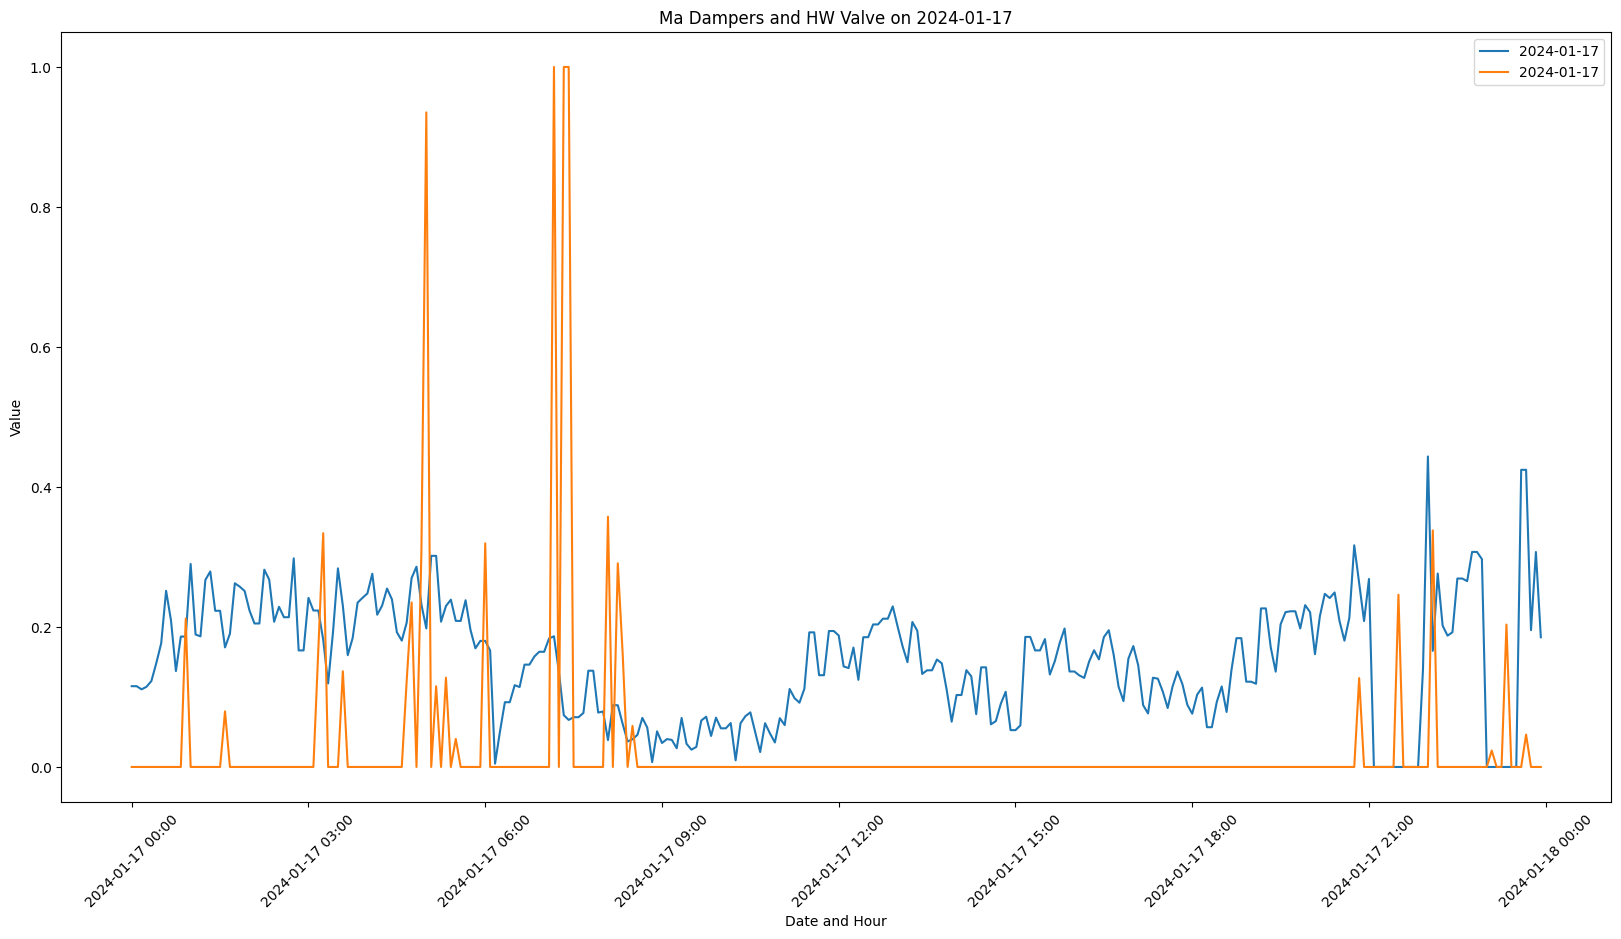

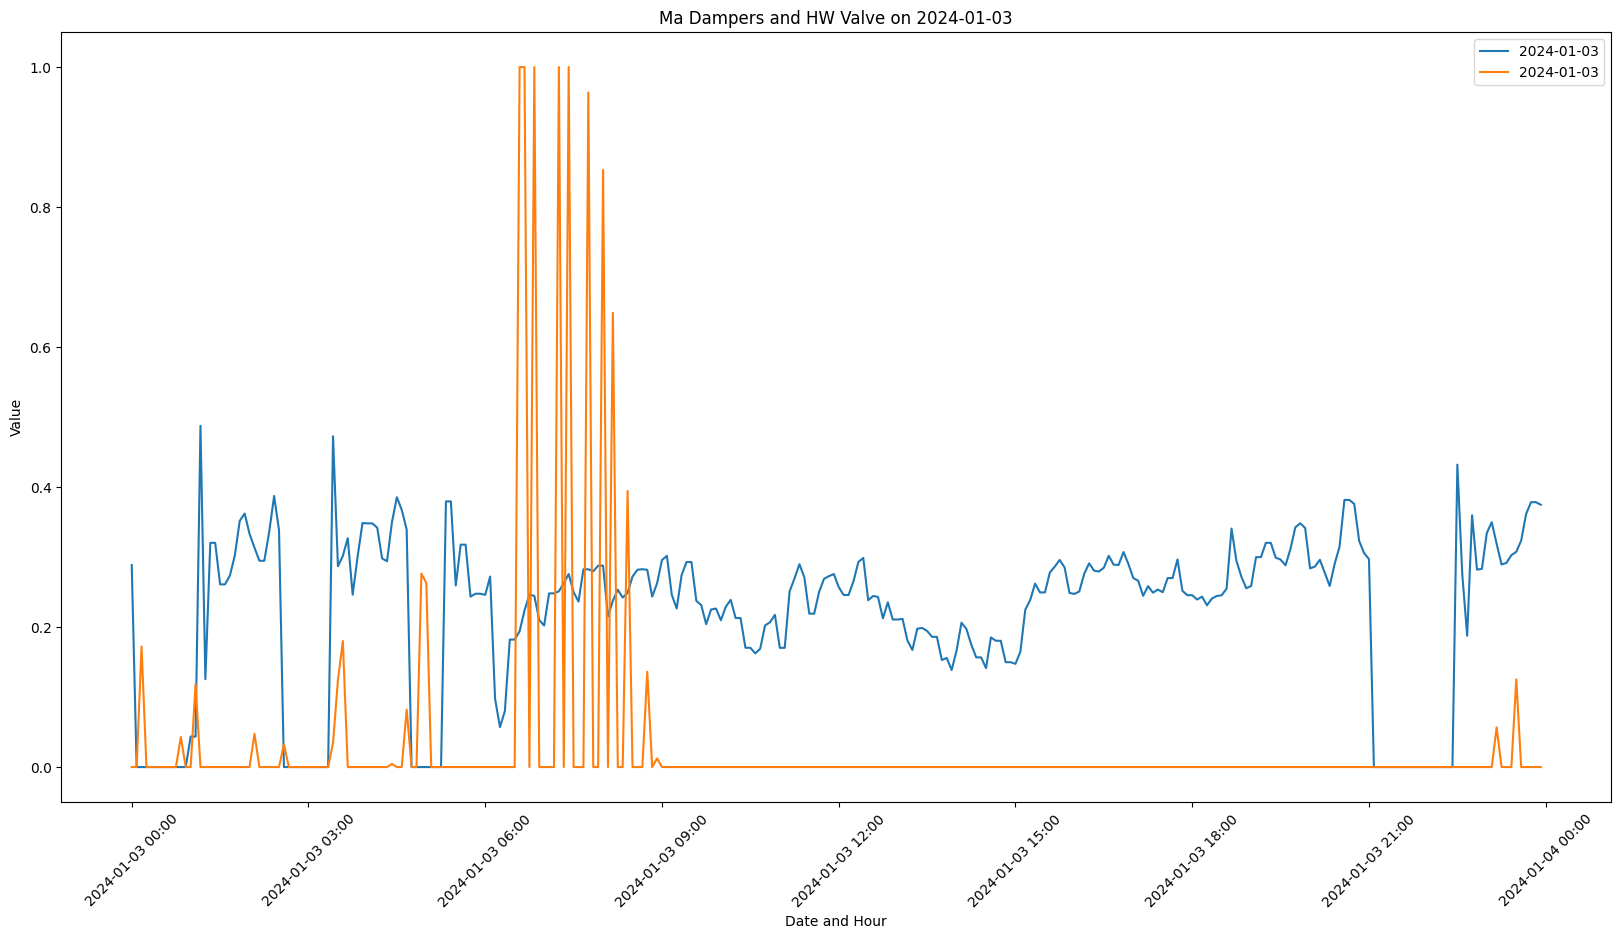

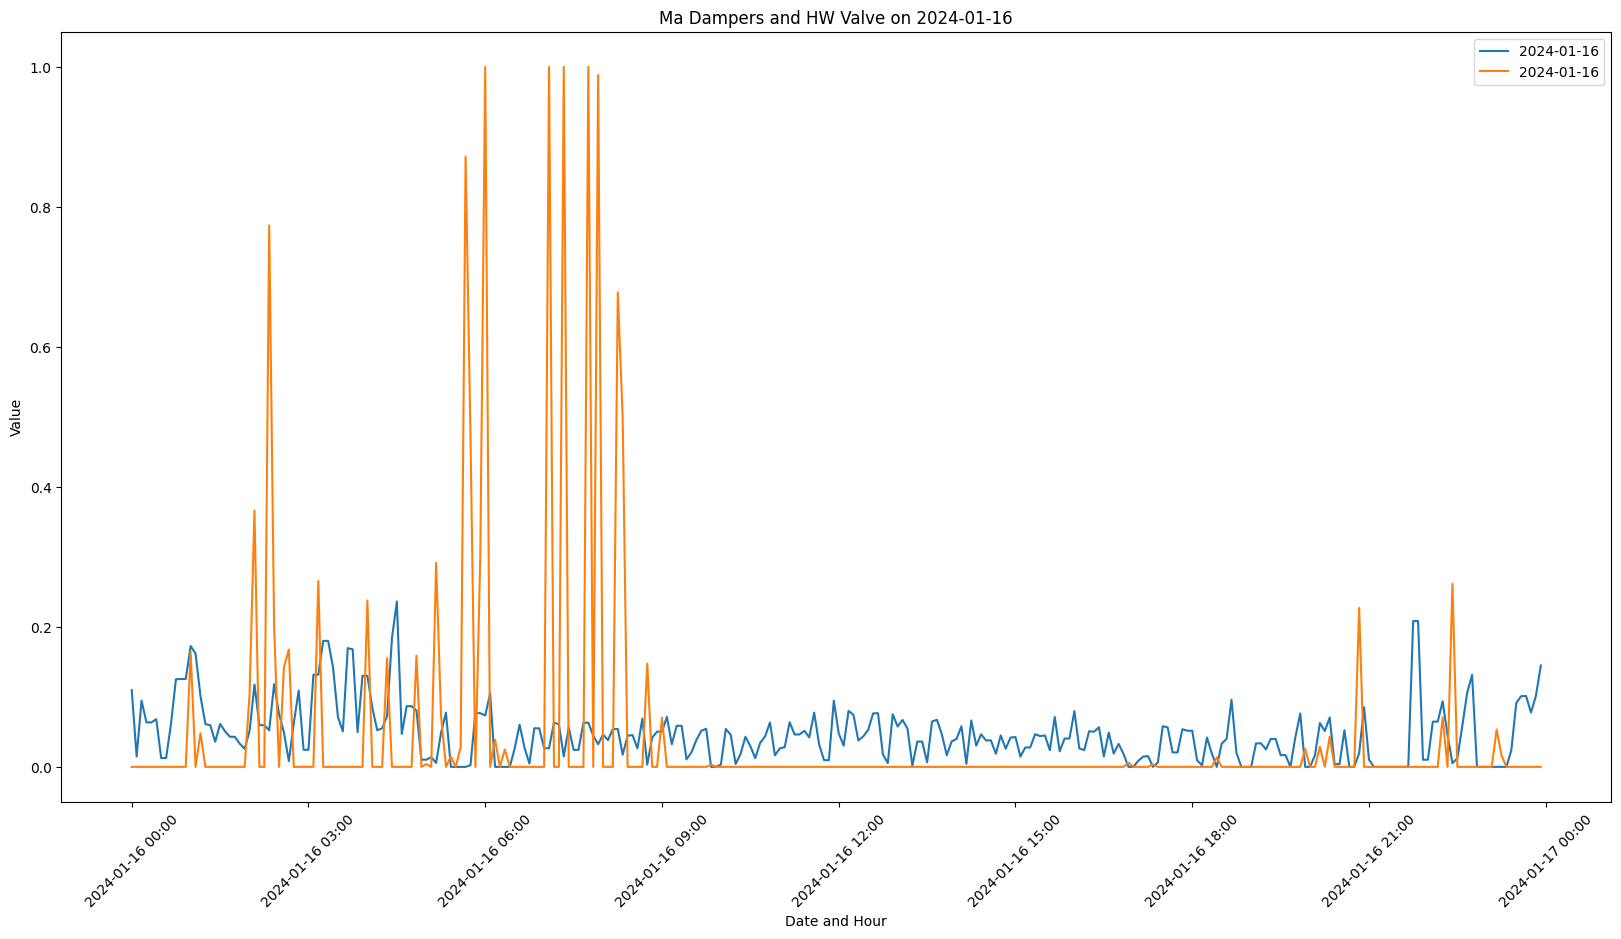

In [33]:

# Ensure the DataFrame index is in DateTime format
df_combined.index = pd.to_datetime(df_combined.index)

# Select three random days in January 2024
random_days = pd.date_range(start='2024-01-01', end='2024-01-31', freq='D')
random_days = np.random.choice(random_days, 5, replace=False)

for day in random_days:
    # Plot the 'Ma_Dampers' and 'HW_Valve' columns for each of the three random days
    plt.figure(figsize=(20, 10))

    day = pd.Timestamp(day)  # Convert numpy.datetime64 to pandas Timestamp
    day_str = day.strftime('%Y-%m-%d')
    df_specific_day = df_combined.loc[day_str]

    plt.plot(df_specific_day.index, df_specific_day[['Ma_Dampers', 'HW_Valve']], label=day_str)

    # Set plot title and labels
    plt.title(f'Ma Dampers and HW Valve on {day_str}')
    plt.xlabel('Date and Hour')
    plt.ylabel('Value')
    plt.legend()

    # Format the x-axis to show the date and hour
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()


The key takeaway is to plot a month's worth of data at a time in reports. It seems this AHU is over-economizing during the winter, which could lead to excessive reheat use, potentially saving natural gas if corrected. If the VAV boxes need to compensate for the AHU cooling in winter, additional heating will be required in the spaces.

Address that discharge air PID hunting issue as well! Also, remember that IPython has a handy feature allowing you to copy plots to the clipboard, making it easy to paste them into Word documents for reports or emails to your client.

## Stay tunned...

Future plans include experimenting with BRICK models, reading data from a database, and writing back to the database when a fault occurs in the Pandas DataFrame, making the results viewable in Grafana.